<a href="https://colab.research.google.com/github/RP2025/Machine-Learning-Lab-CS4172/blob/main/2021CSB029_Assignment05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

## Raksha Pahariya | 2021CSB029

## **Question 01**
Download and extract the flower image dataset from https://www.kaggle.com/alxmamaev/flowers-recognition.

In [1]:
# Download the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

path=path+'/flowers'

print("Path to dataset files:", path)

100%|██████████| 225M/225M [00:02<00:00, 81.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers


In [2]:
import os

os.listdir(path)

['sunflower', 'tulip', 'rose', 'daisy', 'dandelion']

## **Question 02**
The dataset contains five classes of flower images of variable size namely
chamomile, tulip, rose, sunflower, and dandelion. Resize all images to 80 × 80
pixels and convert all colour images to grey images.

In [3]:
# Image Parameters
N_CLASSES = 5
IMG_SIZE = 80
DIR=path
FLOWER_DAISY_DIR=path+'/daisy'
FLOWER_SUNFLOWER_DIR=path+'/sunflower'
FLOWER_TULIP_DIR=path+'/tulip'
FLOWER_DANDI_DIR=path+'/dandelion'
FLOWER_ROSE_DIR=path+'/rose'

In [4]:
X=[]  # Contains the image
Y=[]  # Contains the labels

In [5]:
!pip install tqdm

In [6]:
from tqdm import tqdm
from PIL import Image
import numpy as np

def train_data(flower_type,path_dir):
  for img in tqdm(os.listdir(path_dir)):
        label=flower_type
        path = os.path.join(path_dir,img)
        img_array = Image.open(path).convert('L')
        img_array = img_array.resize((IMG_SIZE,IMG_SIZE))
        img_array = np.array(img_array)
        X.append(np.array(img_array))
        Y.append(str(label))

In [7]:
train_data('Daisy',FLOWER_DAISY_DIR)
train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
train_data('Tulip',FLOWER_TULIP_DIR)
train_data('Dandelion',FLOWER_DANDI_DIR)
train_data('Rose',FLOWER_ROSE_DIR)

100%|██████████| 784/784 [00:06<00:00, 126.45it/s]


In [8]:
print(f"The number of samples in the dataset is {len(X)}")

The number of samples in the dataset is 4317


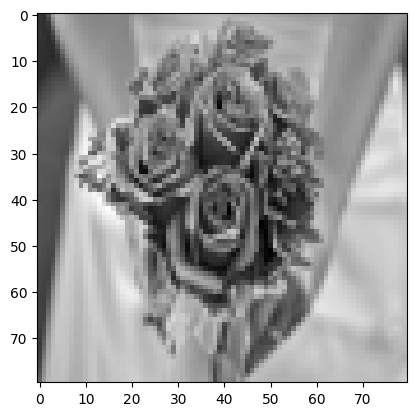

Rose


In [9]:
import matplotlib.pyplot as plt

plt.imshow(X[4235],cmap='gray')
plt.show()

print(Y[4235])

## **Question 03**
Randomly shuffle all images to create training, test set with ratio 90: 10,
respectively. (Reduce the training size by 1/5, if computation resources are
limited.)

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_rem,y_train,y_rem = train_test_split(X,Y,test_size=0.2,random_state=7)
X_test,X_val,y_test,y_val=train_test_split(X_rem,y_rem,test_size=0.5,random_state=7)

print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

3453
3453
432
432
432
432


In [11]:
# Convert to np array for tf processing
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

# Reshape
X_train = X_train.reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test.reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val = X_val.reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [12]:
# One hot encode the labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(['Daisy','Sunflower','Tulip','Dandelion','Rose'])

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

import pandas as pd

y_train = pd.get_dummies(y_train,dtype='int').to_numpy()
y_test = pd.get_dummies(y_test,dtype='int').to_numpy()
y_val = pd.get_dummies(y_val,dtype='int').to_numpy()

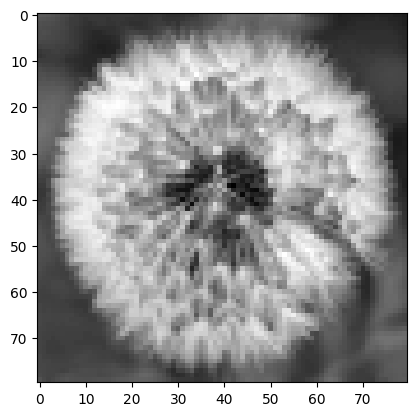

[0 1 0 0 0]


In [13]:
import matplotlib.pyplot as plt

plt.imshow(X_train[135],cmap='gray')
plt.show()

print(y_train[135])

## **Question 04**
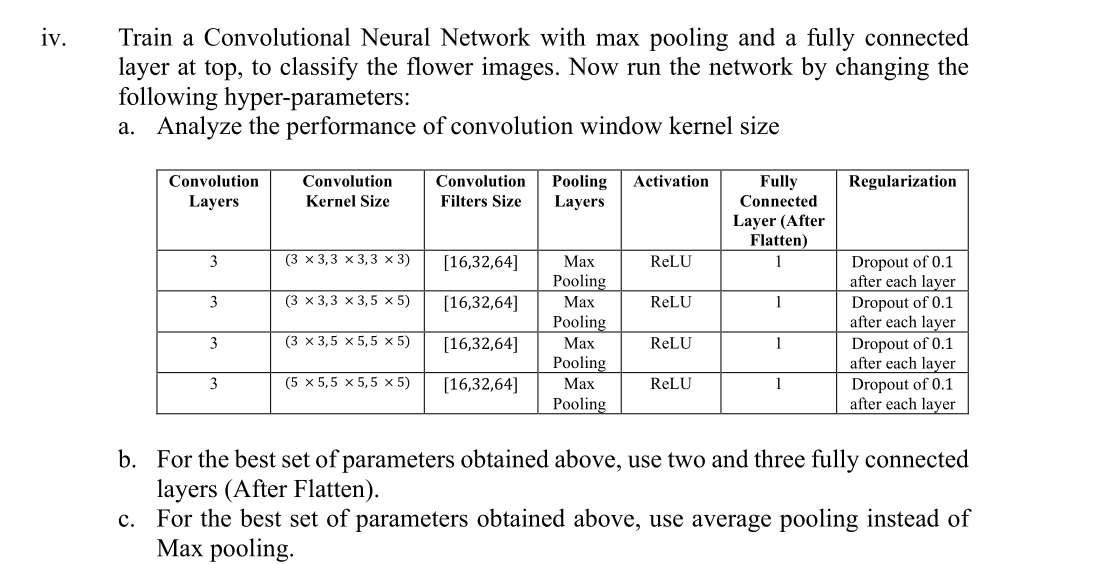

In [14]:
# Import necessary libraries
import tensorflow as tf

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, \
                            Dropout, BatchNormalization, LeakyReLU

from tensorflow.keras.metrics import F1Score
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [16]:
# Plot the accuracy and loss metrics of the model

def plot_model_metrics(
    history: 'tf.keras.callbacks.history',
    kernels: 'list(tuple(int,int))',
    filters: 'list(int)',
    activation_func: 'str',
    pool: 'str',
    num_dense_layers: 'int'
):
  plt.plot(history.history['loss'],label='Training loss')
  plt.plot(history.history['val_loss'],label='Validation loss')

  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.title(f"Filters: {filters}, Kernels: {kernels}, {pool} pool, {activation_func} activation function, No. of dense layers after flatten: {num_dense_layers}")

  plt.show()

  plt.plot(history.history['accuracy'],label='Training accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.title(f"Filters: {filters}, Kernels: {kernels}, {pool} pool, {activation_func} activation function, No. of dense layers after flatten: {num_dense_layers}")

  plt.show()

In [17]:
# Plot the confusion matrix of the model
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(
  y_test: 'list(int)',
  y_pred: 'list(int)'
):
  matrix = confusion_matrix(y_test,y_pred)
 # matrix = matrix.numpy()
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=label_encoder.classes_)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix for the above model")
  plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

def plot_confusion_matrix_mnist(y_test, y_pred):
  """Plots the confusion matrix for the given true and predicted labels, normalised"""
  label_encoder = LabelEncoder()
  label_encoder.fit(np.unique(np.concatenate((y_test, y_pred))))
  matrix = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                display_labels=label_encoder.classes_)
  disp.plot(cmap=plt.cm.Blues,
            xticks_rotation='vertical',
            include_values=True,
            values_format=".2f"
           )
  plt.title("Confusion Matrix for the above model")
  plt.tight_layout()
  plt.show()

In [19]:
# Train the model

import time

def train_model(
    kernels: 'list(tuple(int,int))',
    filters: 'list(int)',
    activation_func:'str',
    pool: 'str',
    dropout_rate: 'float',
    num_dense_layers: 'int',
    X_train: 'numpy.array',
    y_train: 'numpy.array',
    X_test: 'numpy.array',
    y_test: 'numpy.array',
    add_batch_normalization=False,
    flatten_layer_size=64,
    num_epochs = 100,
    extra_conv_layers=0,
    is_rgb=False,
    is_mnist=False
):

  model = Sequential()
  input_shape=(80,80,1)
  num_classes=5
  val_data=(X_val,y_val)
  if is_rgb:
    input_shape=(80,80,3)
    val_data=(X_val_rgb,y_val_rgb)
  if is_mnist:
    num_classes=10
  for filter,kernel in zip(filters,kernels):
    if activation_func=='leaky_relu':
      model.add(Conv2D(
          filters=filter,
          kernel_size=kernel,
          activation=LeakyReLU(alpha=0.01)
          ))
    else:
      model.add(Conv2D(
          filters=filter,
          kernel_size=kernel,
          activation=activation_func
          ))

    if pool=='max':
      model.add(MaxPool2D())
    else:
      model.add(AveragePooling2D(pool_size=(2,2)))

    if add_batch_normalization:
      model.add(BatchNormalization())

    if dropout_rate>0:
      model.add(Dropout(rate=dropout_rate))

    # Extra Conv Layers
    for i in range(0,extra_conv_layers):
      filters.append(filters[-1]*2)
      kernels.append(kernels[-1])
      if activation_func=='leaky_relu':
        model.add(Conv2D(
            filters=filters[-1],
            kernel_size=kernels[-1],
            activation=LeakyReLU(alpha=0.01),
            padding='valid'
            ))
      else:
        model.add(Conv2D(
            filters=filters[-1],
            kernel_size=kernels[-1],
            activation=activation_func,
            padding='valid'
            ))

    model.add(Flatten())

    for i in range(num_dense_layers):
      if activation_func=='leaky_relu':
        model.add(Dense(
            units=flatten_layer_size,
            activation=LeakyReLU(alpha=0.01)
            ))
      else:
        model.add(Dense(
            units=flatten_layer_size,
            activation=activation_func
        ))

    model.add(Dense(units=num_classes,activation='softmax'))

    model.summary()

    model.compile(
                optimizer=Adam(learning_rate=0.002),
                loss=CategoricalCrossentropy,
                metrics=['accuracy',F1Score(average='weighted')]
                )

    callback = [
        EarlyStopping(
            monitor = 'val_loss',
            patience = 10,
            restore_best_weights=True
        )
    ]

    start_time = time.time()

    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=num_epochs,
        validation_data=val_data,
        callbacks=callback
    )

    end_time = time.time()

    train_time=end_time-start_time

    test_loss, test_accuracy ,test_f1 = model.evaluate(X_test,y_test)

    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test F1 Score: {test_f1}")

    print(f"Time required to train the model is {train_time} seconds")

    plot_model_metrics(
        history=history,
        kernels=kernels,
        filters=filters,
        activation_func=activation_func,
        pool=pool,
        num_dense_layers=num_dense_layers
    )

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred,axis=1)
    y_true_classes = np.argmax(y_test,axis=1)

    if is_mnist:
      plot_confusion_matrix_mnist(
        y_test=y_true_classes,
        y_pred=y_pred_classes
      )
    else:
      plot_confusion_matrix(
        y_test=y_true_classes,
        y_pred=y_pred_classes
      )

    return test_loss,test_accuracy,test_f1,train_time,model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.2270 - f1_score: 0.2245 - loss: 104.0952 - val_accuracy: 0.2222 - val_f1_score: 0.2126 - val_loss: 2.4210
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4085 - f1_score: 0.4075 - loss: 1.4910 - val_accuracy: 0.2477 - val_f1_score: 0.2428 - val_loss: 2.2861
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5933 - f1_score: 0.5937 - loss: 1.0125 - val_accuracy: 0.2407 - val_f1_score: 0.2355 - val_loss: 2.4412
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - f1_score: 0.7195 - loss: 0.7619 - val_accuracy: 0.2593 - val_f1_score: 0.2551 - val_loss: 2.7529
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7981 - f1_score: 0.7992 - loss: 0.6361 - val_accuracy: 0.2662 - val_f1_score: 0.2641 - val_loss: 3.0625
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8370 - f1_score: 0.8380 - loss: 0.5521 - val_accuracy: 0.2685 - val_f1_score: 0.

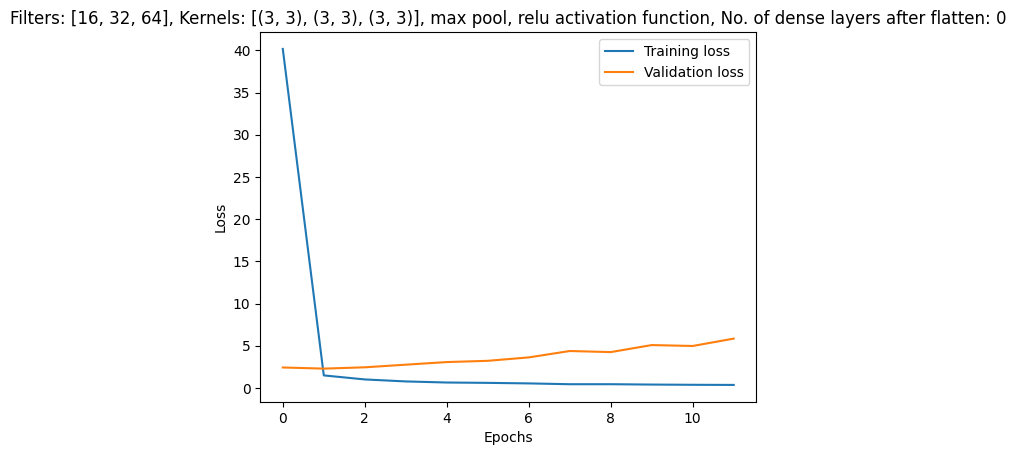

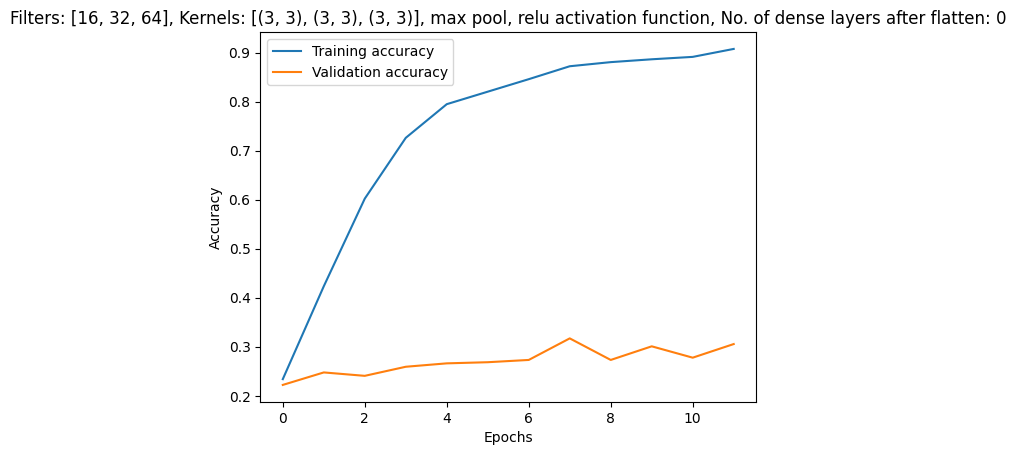

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


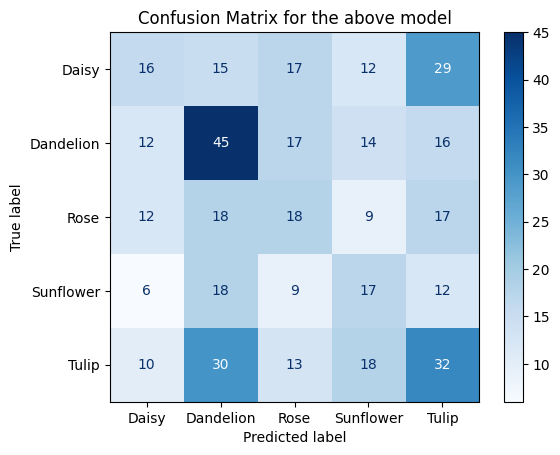

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2133 - f1_score: 0.2098 - loss: 188.1229 - val_accuracy: 0.3079 - val_f1_score: 0.3052 - val_loss: 2.3538
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4577 - f1_score: 0.4578 - loss: 1.4318 - val_accuracy: 0.2986 - val_f1_score: 0.2934 - val_loss: 2.2873
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6295 - f1_score: 0.6303 - loss: 0.9633 - val_accuracy: 0.3009 - val_f1_score: 0.2967 - val_loss: 2.5335
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - f1_score: 0.7552 - loss: 0.7101 - val_accuracy: 0.3171 - val_f1_score: 0.3107 - val_loss: 2.6981
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8077 - f1_score: 0.8098 - loss: 0.5862 - val_accuracy: 0.2963 - val_f1_score: 0.2914 - val_loss: 3.0017
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - f1_score: 0.8485 - loss: 0.4936 - val_accuracy: 0.3218 - val_f1_score: 0.3

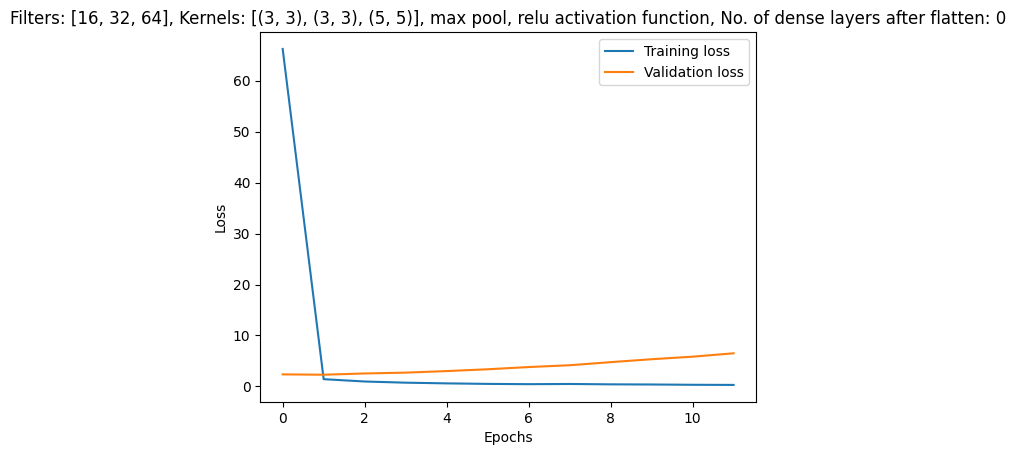

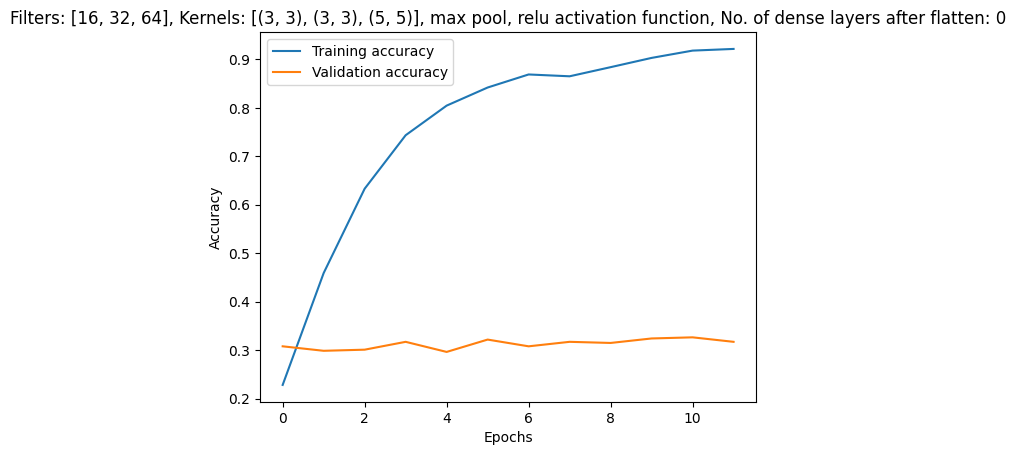

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


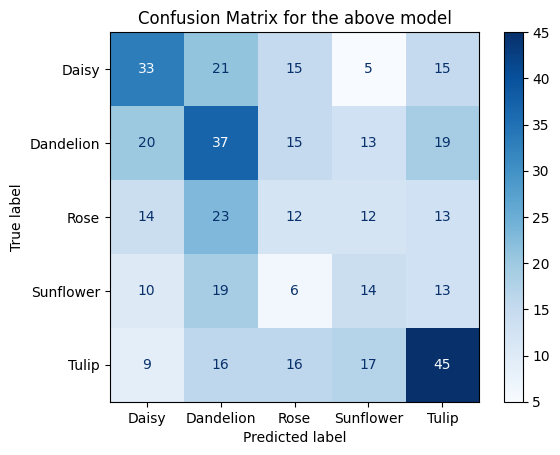

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2559 - f1_score: 0.2540 - loss: 100.1302 - val_accuracy: 0.2523 - val_f1_score: 0.2475 - val_loss: 2.1889
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4992 - f1_score: 0.4984 - loss: 1.3311 - val_accuracy: 0.2477 - val_f1_score: 0.2403 - val_loss: 2.2481
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6408 - f1_score: 0.6420 - loss: 0.9261 - val_accuracy: 0.2523 - val_f1_score: 0.2456 - val_loss: 2.4835
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7635 - f1_score: 0.7644 - loss: 0.6875 - val_accuracy: 0.2731 - val_f1_score: 0.2615 - val_loss: 2.7474
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8315 - f1_score: 0.8323 - loss: 0.5248 - val_accuracy: 0.2755 - val_f1_score: 0.2665 - val_loss: 3.1807
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8699 - f1_score: 0.8708 - loss: 0.4468 - val_accuracy: 0.2824 - val_f1_score: 0.2

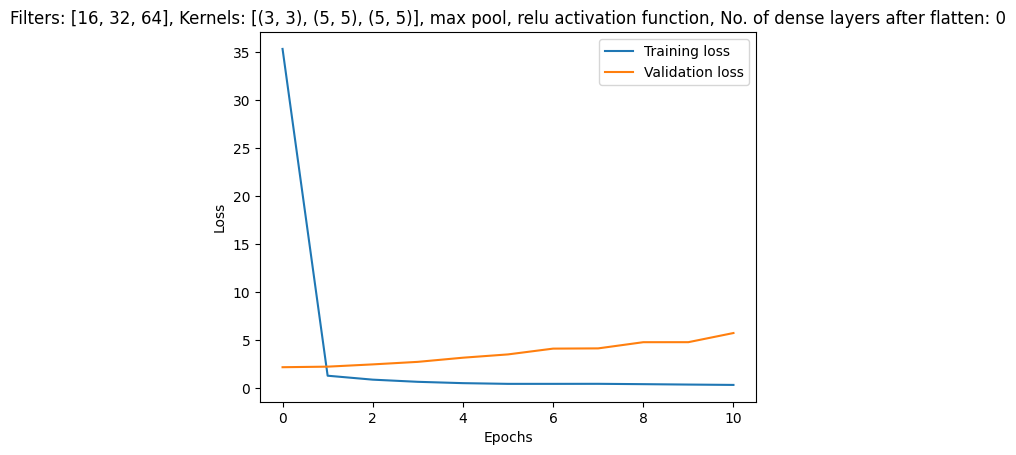

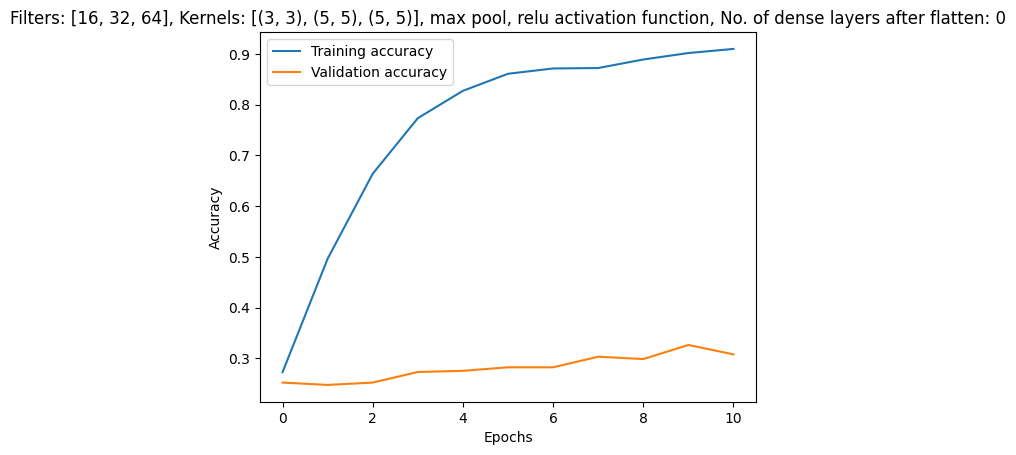

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


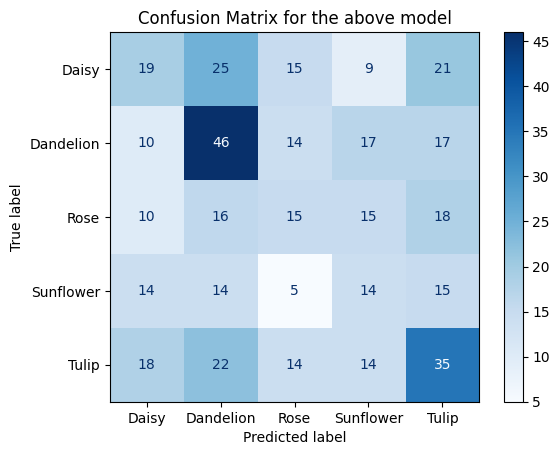

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2116 - f1_score: 0.2098 - loss: 144.5648 - val_accuracy: 0.2454 - val_f1_score: 0.2064 - val_loss: 1.8800
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4041 - f1_score: 0.3907 - loss: 1.4261 - val_accuracy: 0.2593 - val_f1_score: 0.2157 - val_loss: 1.9171
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5098 - f1_score: 0.5081 - loss: 1.1861 - val_accuracy: 0.2569 - val_f1_score: 0.2160 - val_loss: 2.0625
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - f1_score: 0.6266 - loss: 0.9985 - val_accuracy: 0.2431 - val_f1_score: 0.2251 - val_loss: 2.4364
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6809 - f1_score: 0.6866 - loss: 0.8326 - val_accuracy: 0.2569 - val_f1_score: 0.2323 - val_loss: 2.8127
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7208 - f1_score: 0.7281 - loss: 0.7513 - val_accuracy: 0.2593 - val_f1_score: 0.2

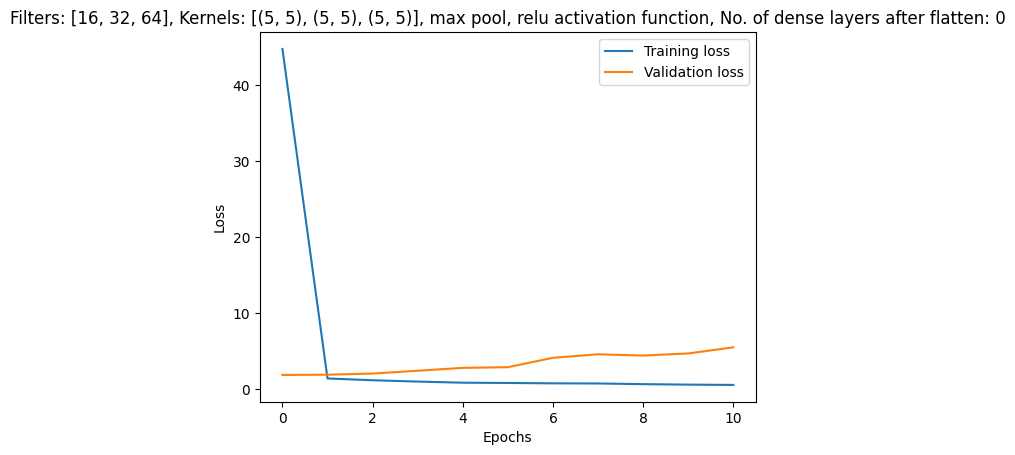

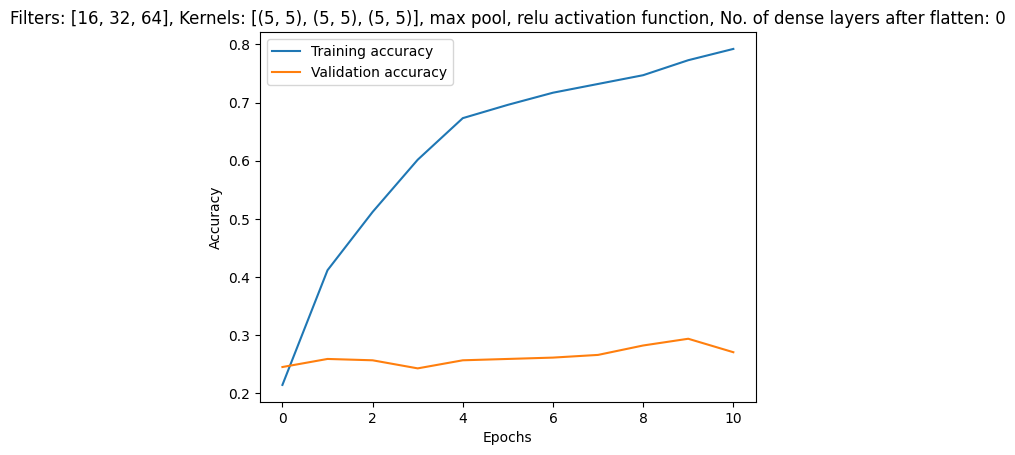

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


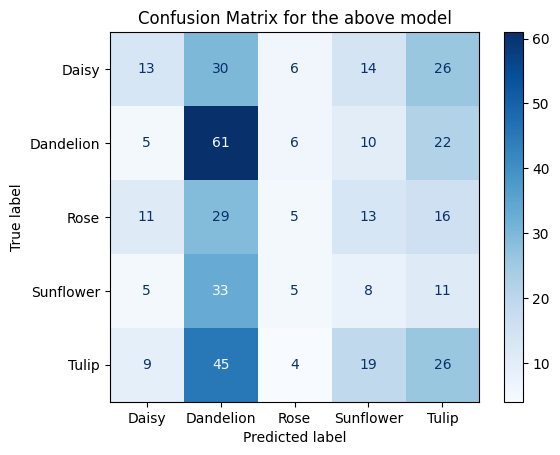

In [20]:
result_df_1 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Training Time(in seconds)'
    ]
)

kernels = [
    [(3,3),(3,3),(3,3)],
    [(3,3),(3,3),(5,5)],
    [(3,3),(5,5),(5,5)],
    [(5,5),(5,5),(5,5)]
]

filters = [16,32,64]
activation='relu'
dropout_rate = 0.1
num_dense_layers = 0
pool='max'
epochs = 20

for kernel in kernels:
  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=kernel,
      filters=filters,
      activation_func=activation,
      pool=pool,
      dropout_rate=dropout_rate,
      num_dense_layers=num_dense_layers,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs
  )

  result_df_1.loc[len(result_df_1.index)]=[
      kernel,
      filters,
      pool,
      activation,
      num_dense_layers,
      dropout_rate,
      test_loss,
      test_accuracy,
      test_f1,
      train_time
  ]

In [21]:
result_df_1

,Conv Kernel Size,Conv Filter Size,Pooling Layers,Activation Function,No. of Dense Layers after Flatten,Dropout Rate,Test Loss,Test Accuracy,Test F1 Score,Training Time(in seconds)
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,0,0.1,2.016021,0.296296,0.291313,19.573261
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,2.273956,0.326389,0.324301,9.857435
2,"[(3, 3), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,1.933540,0.298611,0.294540,11.634708
3,"[(5, 5), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,1.811836,0.261574,0.233962,11.932267


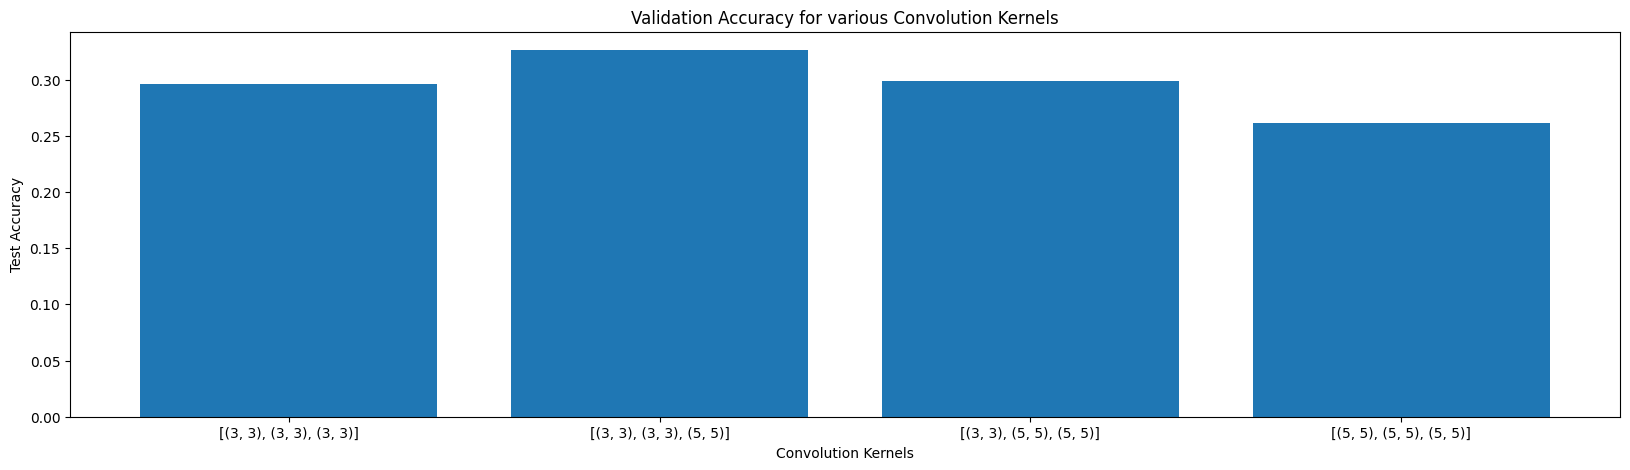

In [22]:
plt.figure(figsize=(20,5))
plt.bar(
    [str(ker) for ker in result_df_1['Conv Kernel Size']],
    result_df_1['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('Convolution Kernels')
plt.title('Validation Accuracy for various Convolution Kernels')
plt.show()

In [23]:
best_kernel = result_df_1.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['Conv Kernel Size'].iloc[0]

best_kernel

[(3, 3), (3, 3), (5, 5)]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.2428 - f1_score: 0.2336 - loss: 437.0079 - val_accuracy: 0.2940 - val_f1_score: 0.2882 - val_loss: 2.0489
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3968 - f1_score: 0.3857 - loss: 1.5680 - val_accuracy: 0.3287 - val_f1_score: 0.3178 - val_loss: 1.7946
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5710 - f1_score: 0.5473 - loss: 1.1331 - val_accuracy: 0.3449 - val_f1_score: 0.3416 - val_loss: 1.7965
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6624 - f1_score: 0.6500 - loss: 0.8856 - val_accuracy: 0.3519 - val_f1_score: 0.3500 - val_loss: 1.8566
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7297 - f1_score: 0.7161 - loss: 0.7324 - val_accuracy: 0.3588 - val_f1_score: 0.3580 - val_loss: 1.9869
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7992 - f1_score: 0.7913 - loss: 0.6023 - val_accuracy: 0.3264 - val_f1_score: 0.3

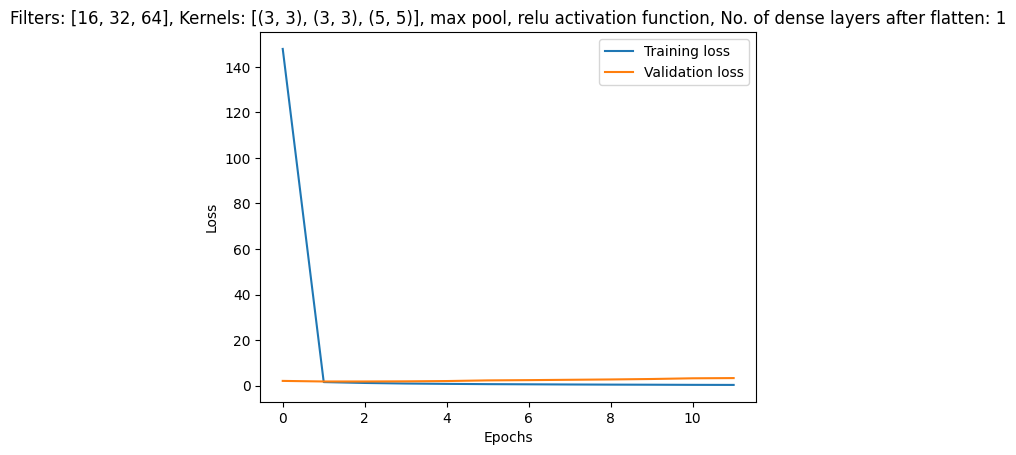

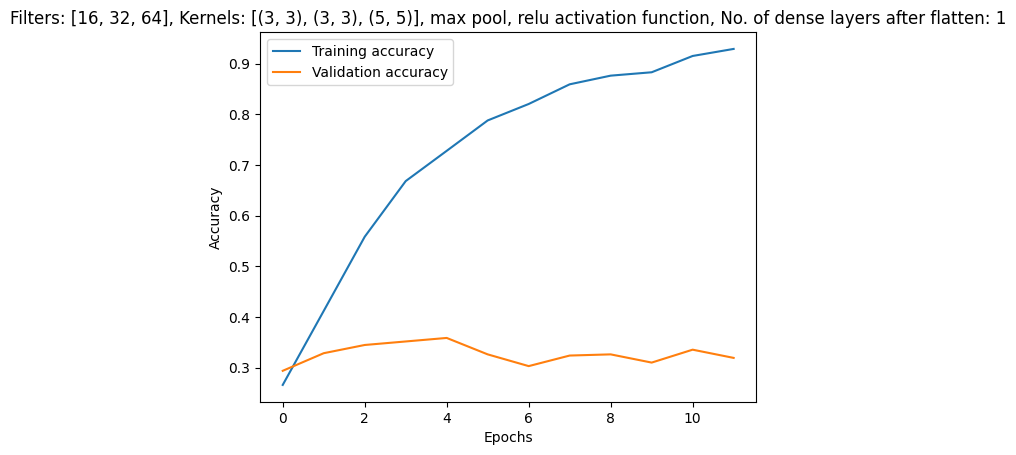

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


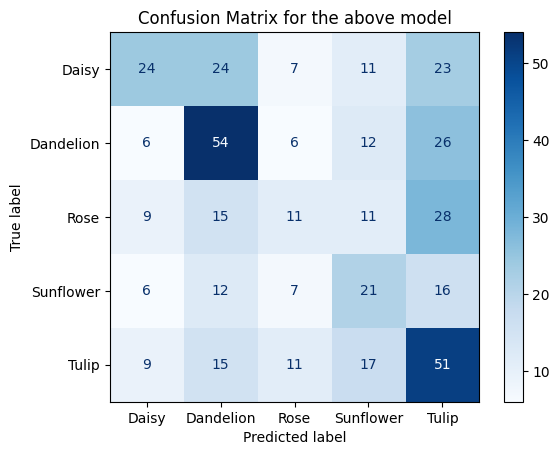

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2351 - f1_score: 0.2319 - loss: 39.1265 - val_accuracy: 0.2986 - val_f1_score: 0.2744 - val_loss: 1.6457
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5229 - f1_score: 0.5078 - loss: 1.3111 - val_accuracy: 0.2986 - val_f1_score: 0.2778 - val_loss: 1.7034
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6841 - f1_score: 0.6826 - loss: 0.9627 - val_accuracy: 0.3472 - val_f1_score: 0.3384 - val_loss: 1.8054
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8057 - f1_score: 0.8058 - loss: 0.6474 - val_accuracy: 0.3310 - val_f1_score: 0.3181 - val_loss: 2.2338
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8895 - f1_score: 0.8898 - loss: 0.4276 - val_accuracy: 0.3241 - val_f1_score: 0.3175 - val_loss: 2.6642
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9085 - f1_score: 0.9085 - loss: 0.3284 - val_accuracy: 0.3148 - val_f1_score: 0.29

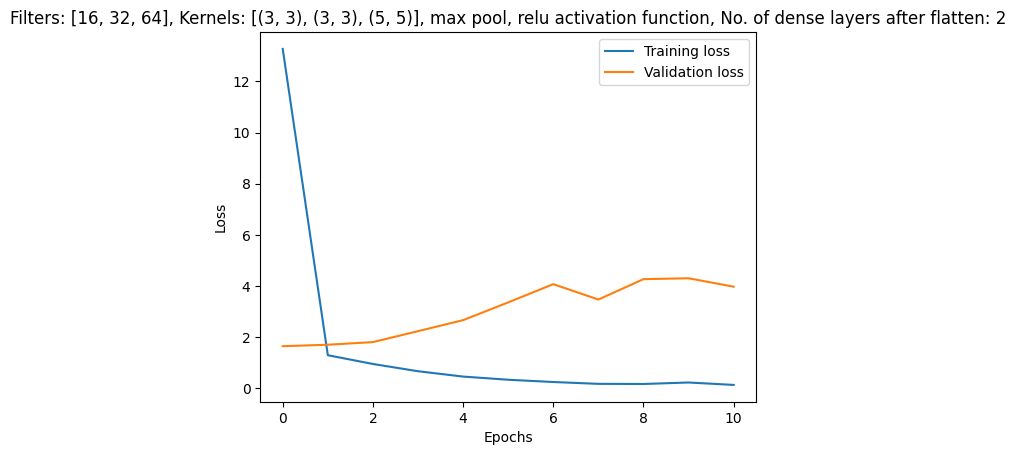

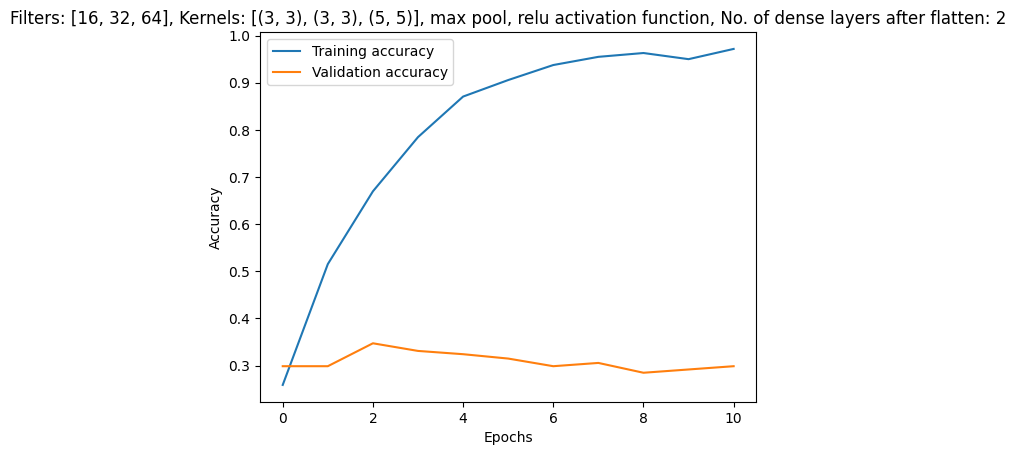

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


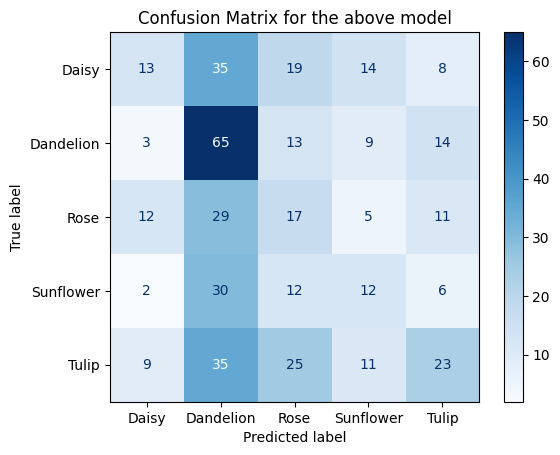

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2351 - f1_score: 0.2307 - loss: 76.8238 - val_accuracy: 0.3472 - val_f1_score: 0.3259 - val_loss: 1.5548
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4888 - f1_score: 0.4860 - loss: 1.3009 - val_accuracy: 0.3704 - val_f1_score: 0.3556 - val_loss: 1.6145
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6192 - f1_score: 0.6175 - loss: 0.9847 - val_accuracy: 0.3565 - val_f1_score: 0.3383 - val_loss: 1.8019
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - f1_score: 0.7531 - loss: 0.7051 - val_accuracy: 0.3819 - val_f1_score: 0.3612 - val_loss: 1.9643
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8647 - f1_score: 0.8655 - loss: 0.4449 - val_accuracy: 0.3750 - val_f1_score: 0.3616 - val_loss: 2.3573
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9068 - f1_score: 0.9072 - loss: 0.3140 - val_accuracy: 0.3681 - val_f1_score: 0.36

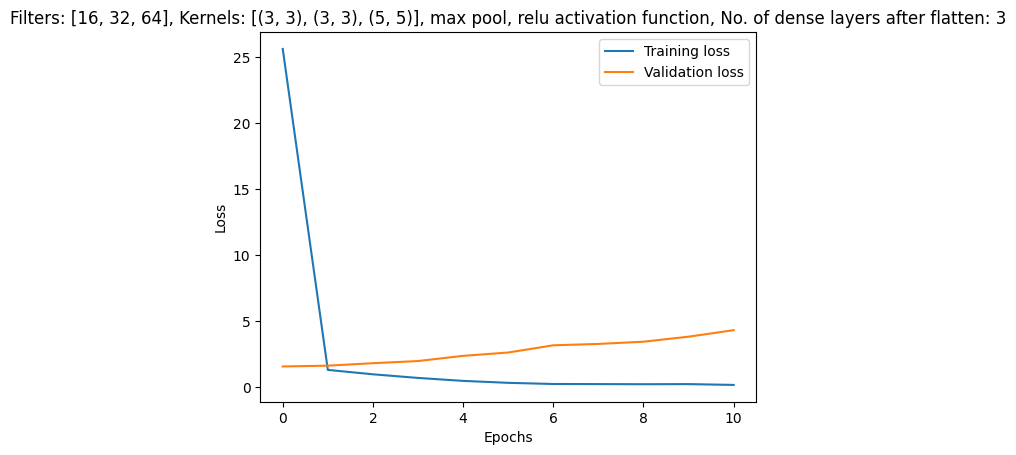

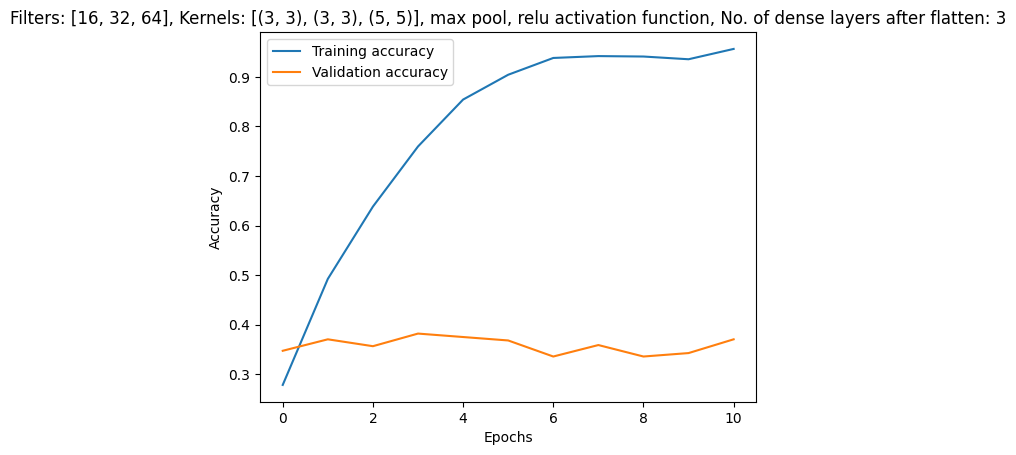

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


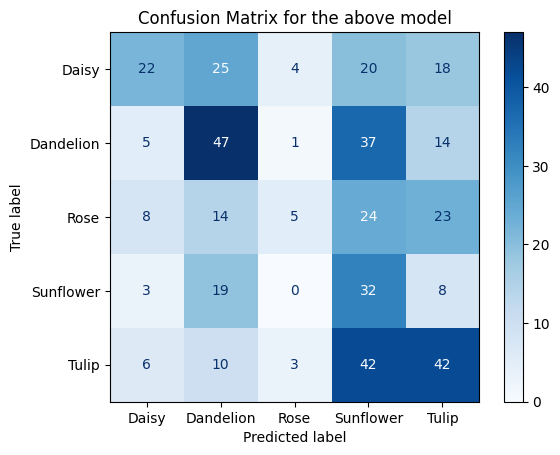

In [24]:
## Subtask 2

result_df_2 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
activation='relu'
dropout_rate = 0.1
pool='max'
epochs = 20
num_dense_layers = [1,2,3]

for layer in num_dense_layers:
  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=activation,
      pool=pool,
      dropout_rate=dropout_rate,
      num_dense_layers=layer,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs
      )

  result_df_2.loc[len(result_df_2.index)]=[
      best_kernel,
      filters,
      pool,
      activation,
      layer,
      dropout_rate,
      test_loss,
      test_accuracy,
      test_f1,
      train_time
  ]

In [25]:
result_df_2

,Conv Kernel Size,Conv Filter Size,Pooling Layers,Activation Function,No. of Dense Layers after Flatten,Dropout Rate,Test Loss,Test Accuracy,Test F1 Score,Training Time(in seconds)
0,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,1,0.1,1.790540,0.372685,0.361154,18.059595
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,2,0.1,1.727204,0.300926,0.280221,13.102227
2,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,3,0.1,1.529928,0.342593,0.329793,17.896032


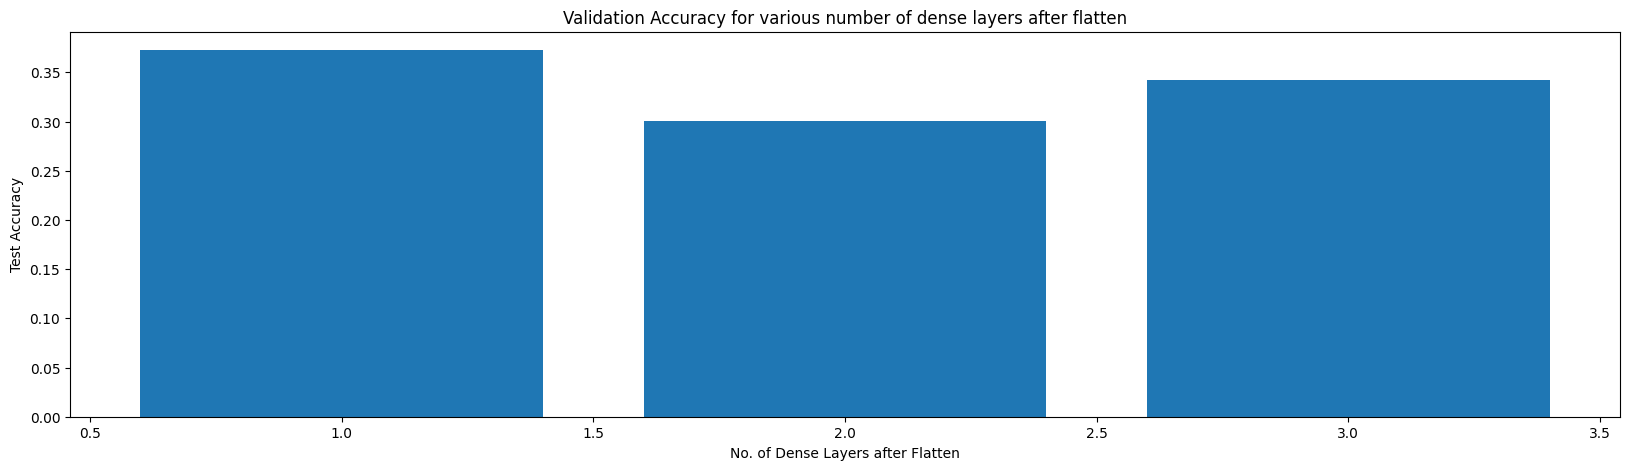

In [26]:
plt.figure(figsize=(20,5))
plt.bar(
    result_df_2['No. of Dense Layers after Flatten'],
    result_df_2['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('No. of Dense Layers after Flatten')
plt.title('Validation Accuracy for various number of dense layers after flatten')
plt.show()

In [27]:
best_num_dense = result_df_2.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['No. of Dense Layers after Flatten'].iloc[0]

best_num_dense

1

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2283 - f1_score: 0.2253 - loss: 260.9627 - val_accuracy: 0.2245 - val_f1_score: 0.2148 - val_loss: 2.4858
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4470 - f1_score: 0.4465 - loss: 1.4933 - val_accuracy: 0.2847 - val_f1_score: 0.2830 - val_loss: 2.2585
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6513 - f1_score: 0.6501 - loss: 0.8898 - val_accuracy: 0.2963 - val_f1_score: 0.2908 - val_loss: 2.6110
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8078 - f1_score: 0.8077 - loss: 0.6093 - val_accuracy: 0.3287 - val_f1_score: 0.3260 - val_loss: 2.5786
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8719 - f1_score: 0.8725 - loss: 0.4566 - val_accuracy: 0.3264 - val_f1_score: 0.3257 - val_loss: 2.9832
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - f1_score: 0.9142 - loss: 0.3538 - val_accuracy: 0.3356 - val_f1_score: 0.3

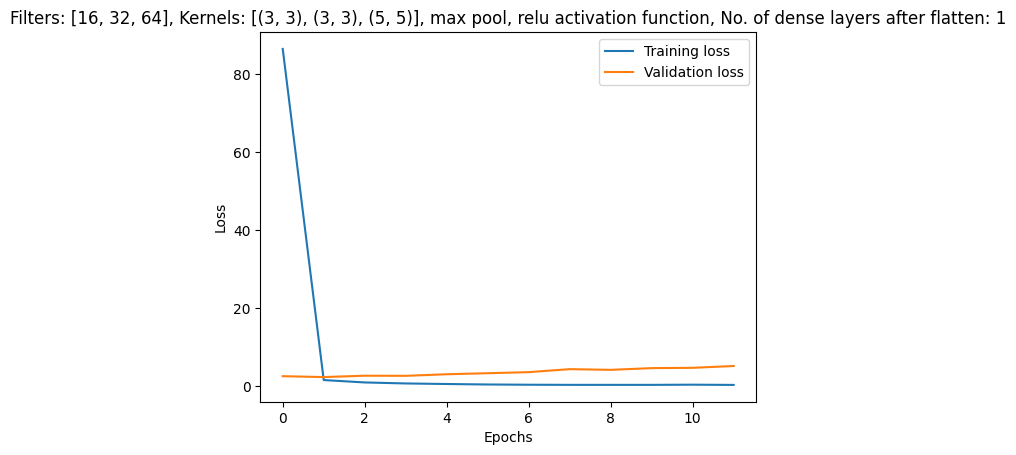

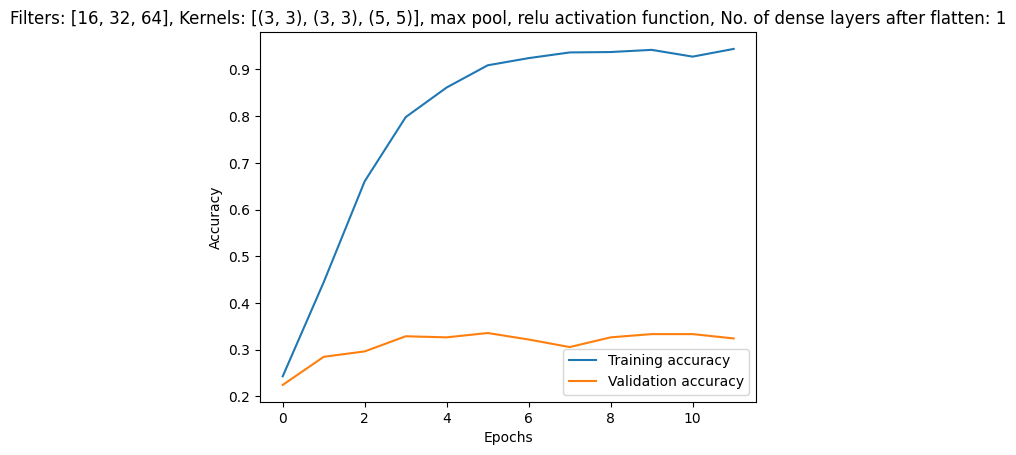

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


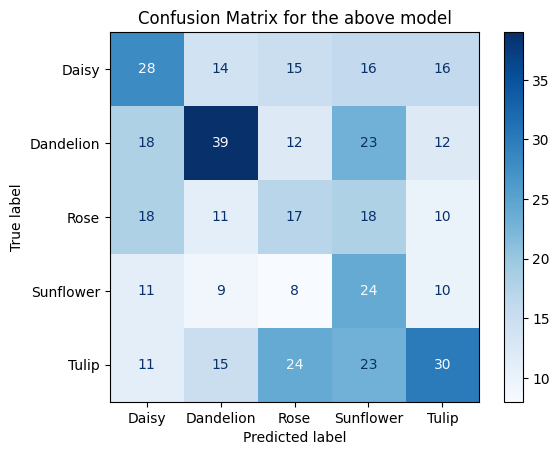

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2236 - f1_score: 0.2193 - loss: 299.8088 - val_accuracy: 0.2546 - val_f1_score: 0.2233 - val_loss: 1.9868
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3731 - f1_score: 0.3666 - loss: 1.6770 - val_accuracy: 0.3542 - val_f1_score: 0.3399 - val_loss: 1.6478
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5547 - f1_score: 0.5513 - loss: 1.1109 - val_accuracy: 0.3750 - val_f1_score: 0.3664 - val_loss: 1.7804
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6723 - f1_score: 0.6696 - loss: 0.8701 - val_accuracy: 0.3472 - val_f1_score: 0.3308 - val_loss: 1.8425
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7576 - f1_score: 0.7579 - loss: 0.6808 - val_accuracy: 0.3773 - val_f1_score: 0.3668 - val_loss: 2.0351
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - f1_score: 0.8172 - loss: 0.5413 - val_accuracy: 0.3565 - val_f1_score: 0.3

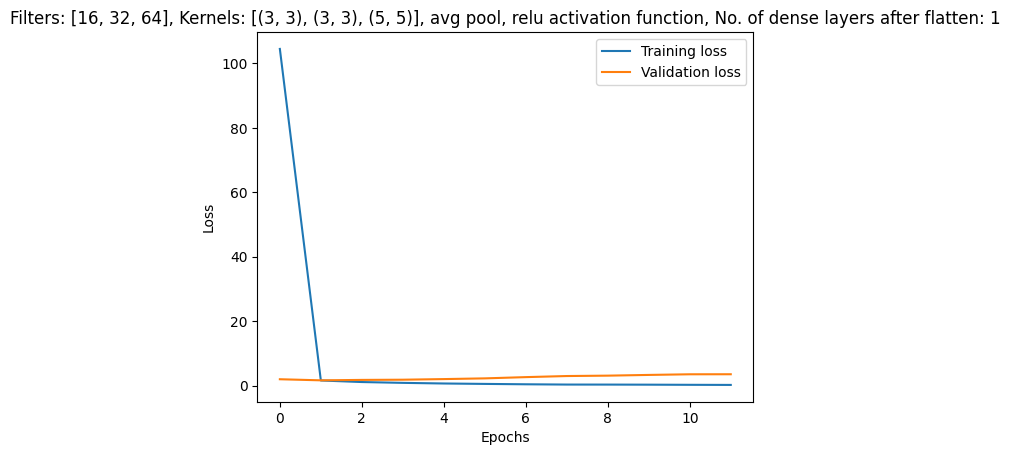

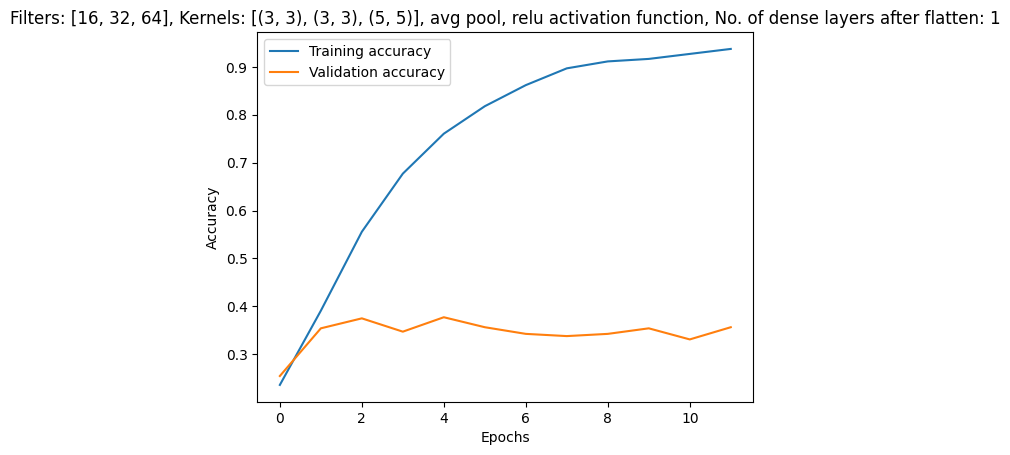

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


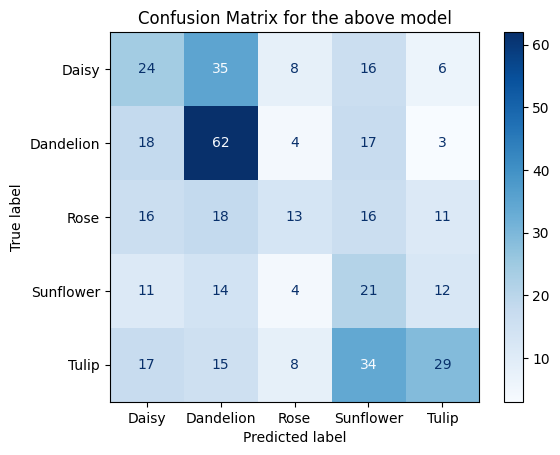

In [28]:
## Subtask 3

result_df_3 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
activation='relu'
dropout_rate = 0.1
pool=['max','avg']
epochs = 20

for p in pool:
  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=activation,
      pool=p,
      dropout_rate=dropout_rate,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs
      )

  result_df_3.loc[len(result_df_3.index)]=[
      best_kernel,
      filters,
      p,
      activation,
      best_num_dense,
      dropout_rate,
      test_loss,
      test_accuracy,
      test_f1,
      train_time
  ]

In [29]:
result_df_3

,Conv Kernel Size,Conv Filter Size,Pooling Layers,Activation Function,No. of Dense Layers after Flatten,Dropout Rate,Test Loss,Test Accuracy,Test F1 Score,Training Time(in seconds)
0,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,1,0.1,2.270587,0.319444,0.323090,10.331060
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",avg,relu,1,0.1,1.633752,0.344907,0.337635,11.734722


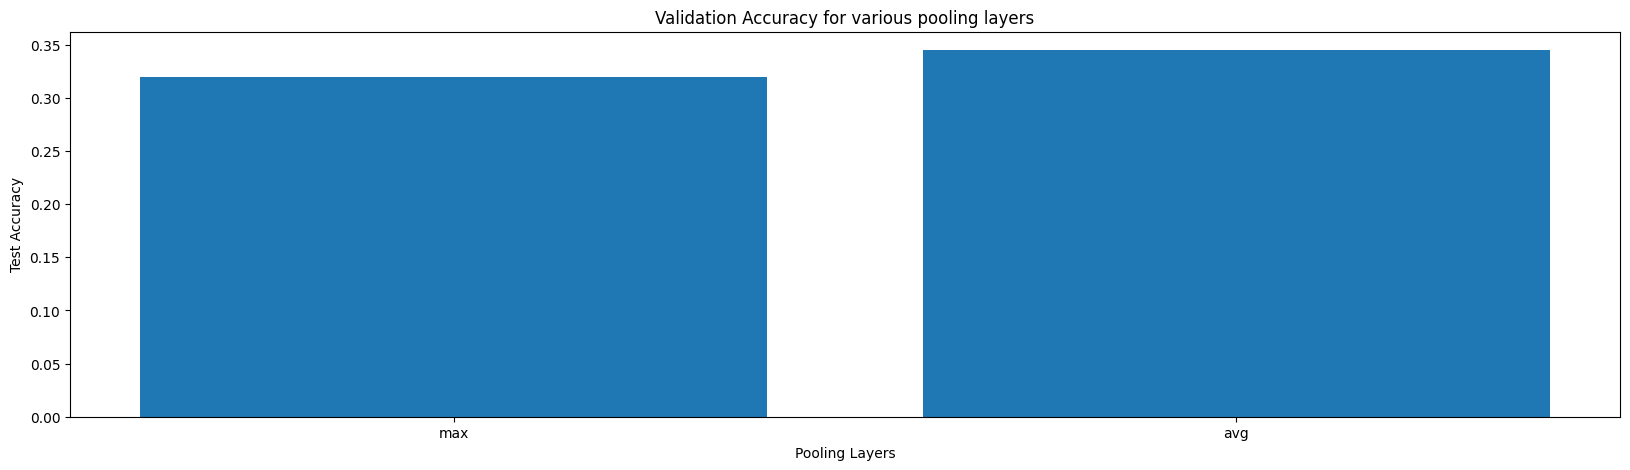

In [30]:
plt.figure(figsize=(20,5))
plt.bar(
    result_df_3['Pooling Layers'],
    result_df_3['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('Pooling Layers')
plt.title('Validation Accuracy for various pooling layers')
plt.show()

In [31]:
best_pool = result_df_3.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['Pooling Layers'].iloc[0]

best_pool

'avg'

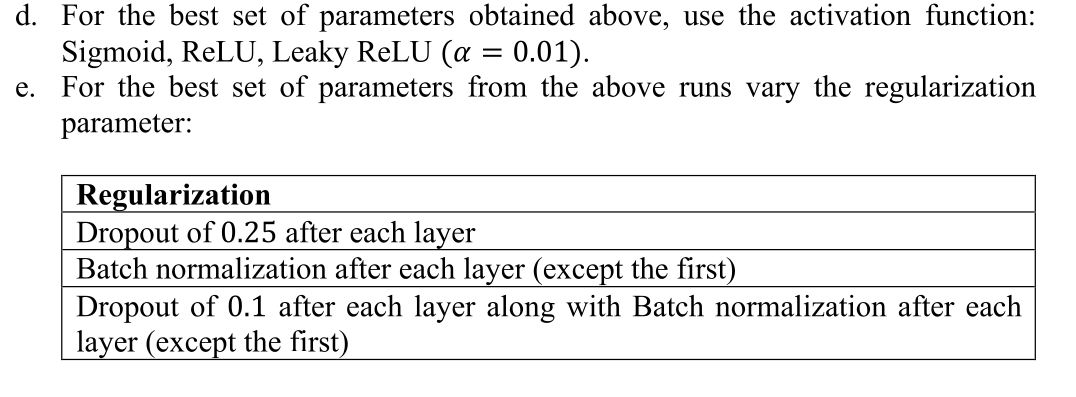

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2407 - f1_score: 0.1530 - loss: 1.9706 - val_accuracy: 0.2083 - val_f1_score: 0.0718 - val_loss: 1.6073
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2465 - f1_score: 0.1385 - loss: 1.5995 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6083
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2262 - f1_score: 0.1378 - loss: 1.6022 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6073
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2305 - f1_score: 0.1237 - loss: 1.6019 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6087
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2399 - f1_score: 0.1510 - loss: 1.5986 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6029
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2179 - f1_score: 0.1335 - loss: 1.6052 - val_accuracy: 0.2083 - val_f1_score: 0.071

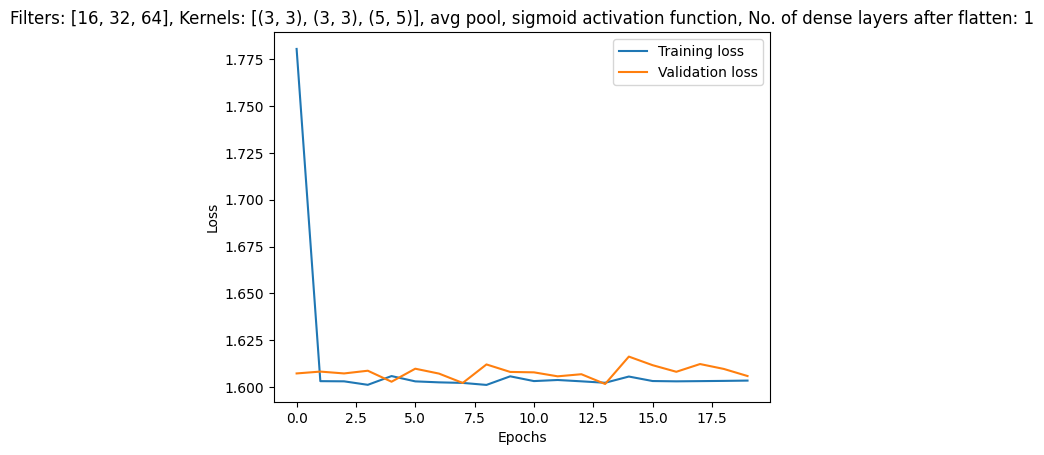

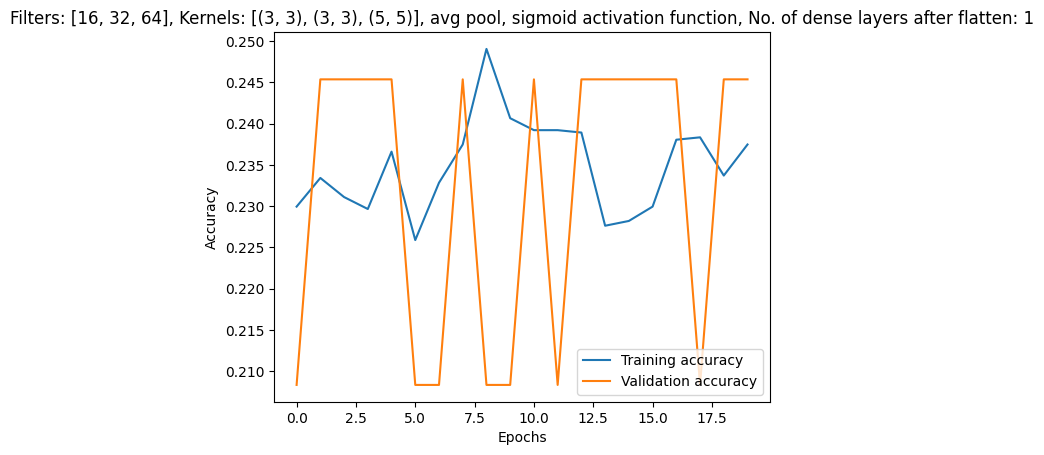

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


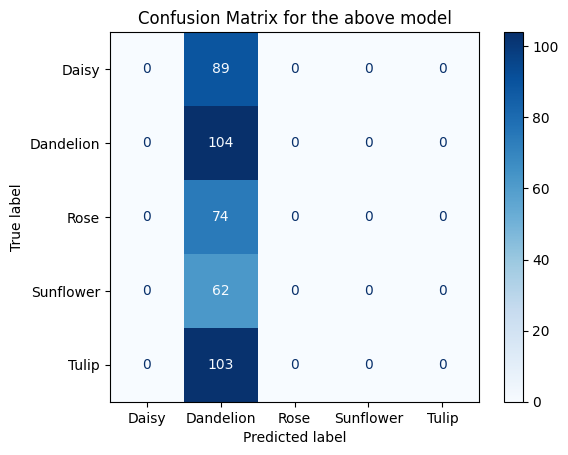

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2015 - f1_score: 0.1842 - loss: 291.7879 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6064
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2555 - f1_score: 0.1048 - loss: 1.6066 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6043
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2442 - f1_score: 0.0961 - loss: 1.6016 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6033
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2333 - f1_score: 0.0906 - loss: 1.6000 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6033
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2452 - f1_score: 0.0970 - loss: 1.5963 - val_accuracy: 0.2454 - val_f1_score: 0.0967 - val_loss: 1.6038
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2508 - f1_score: 0.1012 - loss: 1.5953 - val_accuracy: 0.2454 - val_f1_score: 0.0

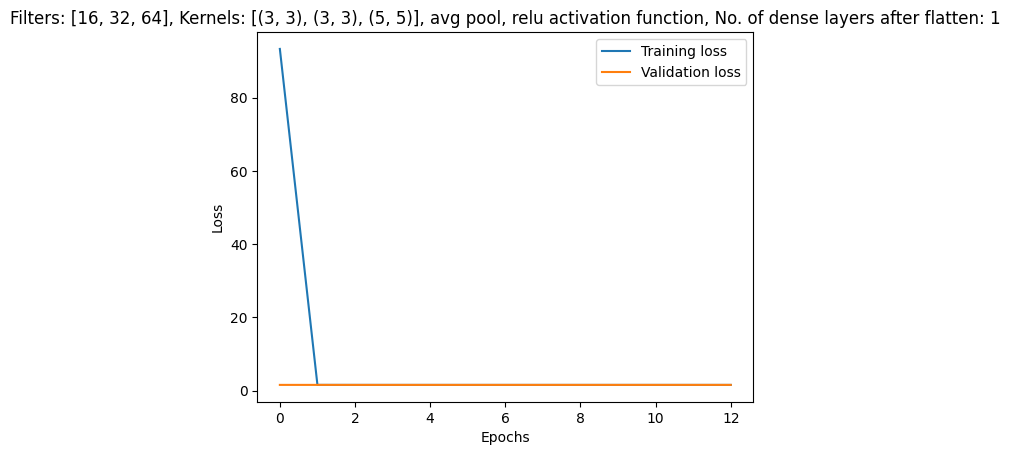

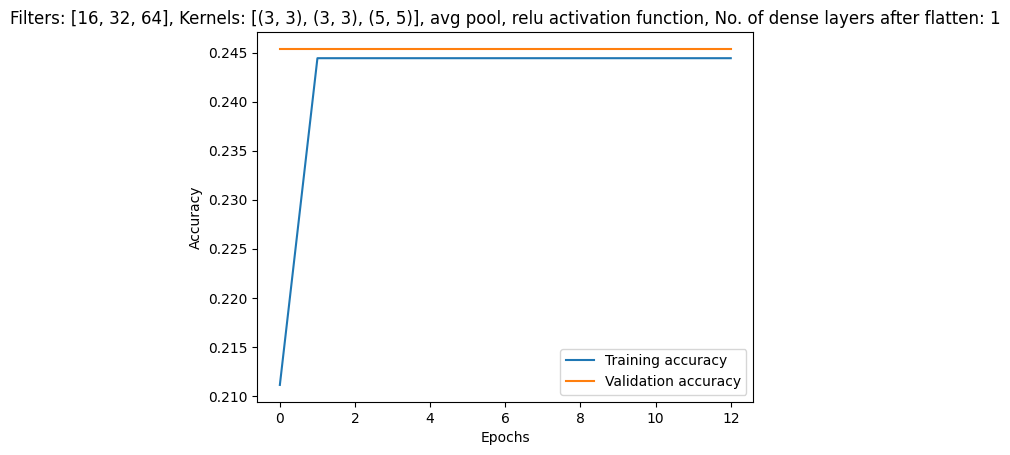

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


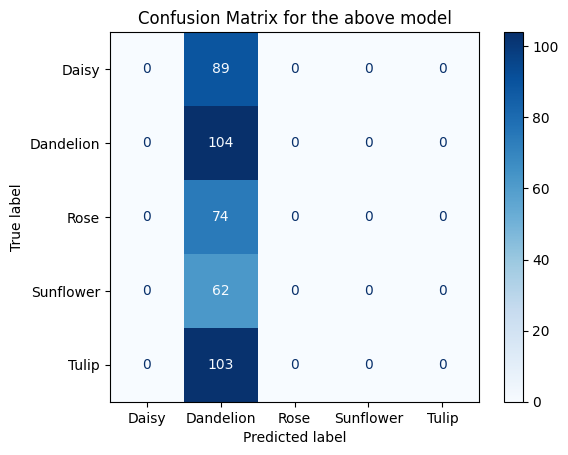

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2365 - f1_score: 0.2181 - loss: 233.7604 - val_accuracy: 0.3495 - val_f1_score: 0.3077 - val_loss: 1.5374
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3628 - f1_score: 0.3144 - loss: 1.5156 - val_accuracy: 0.3542 - val_f1_score: 0.2902 - val_loss: 1.5214
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3799 - f1_score: 0.3340 - loss: 1.4870 - val_accuracy: 0.3704 - val_f1_score: 0.3450 - val_loss: 1.4893
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4150 - f1_score: 0.3896 - loss: 1.4481 - val_accuracy: 0.3519 - val_f1_score: 0.3175 - val_loss: 1.4924
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4218 - f1_score: 0.4044 - loss: 1.4111 - val_accuracy: 0.3403 - val_f1_score: 0.2847 - val_loss: 1.4852
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4354 - f1_score: 0.4157 - loss: 1.3733 - val_accuracy: 0.3403 - val_f1_score: 0.3

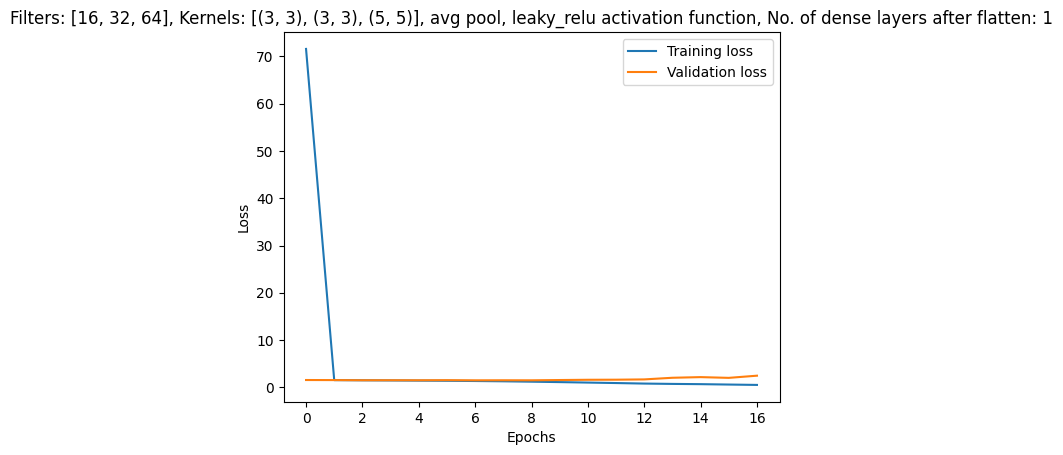

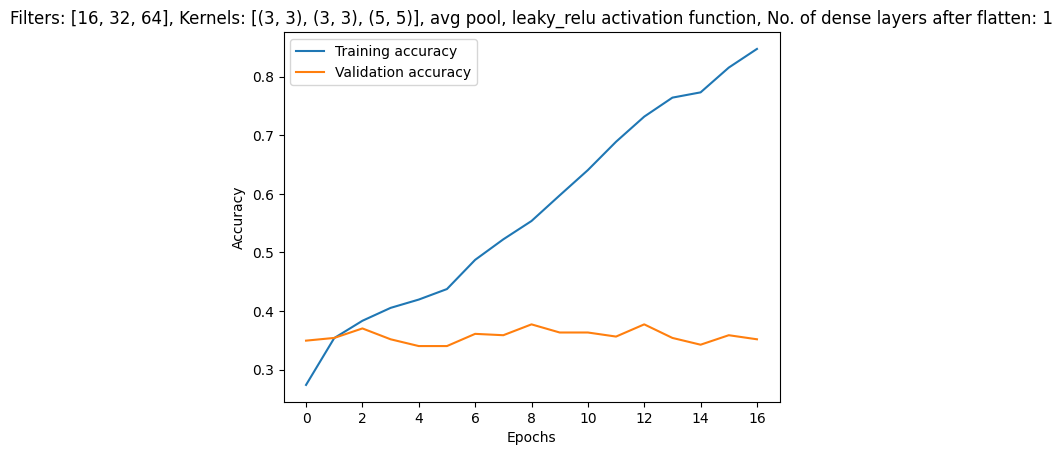

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


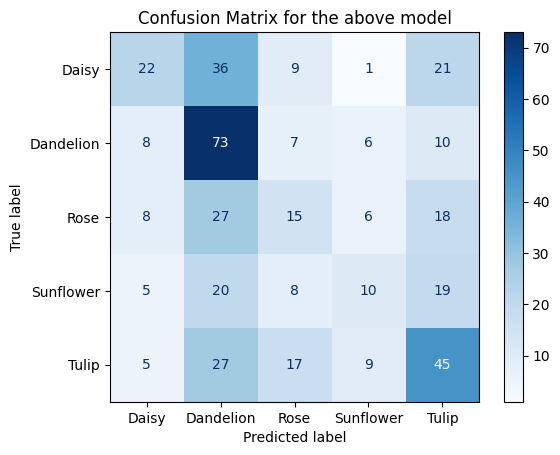

In [32]:
# Subtask 4

result_df_4 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
activation_list=['sigmoid','relu','leaky_relu']
dropout_rate = 0.1
epochs = 20

for activation in activation_list:
  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=activation,
      pool=best_pool,
      dropout_rate=dropout_rate,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs
      )

  result_df_4.loc[len(result_df_4.index)]=[
      best_kernel,
      filters,
      best_pool,
      activation,
      best_num_dense,
      dropout_rate,
      test_loss,
      test_accuracy,
      test_f1,
      train_time
  ]

In [33]:
result_df_4

,Conv Kernel Size,Conv Filter Size,Pooling Layers,Activation Function,No. of Dense Layers after Flatten,Dropout Rate,Test Loss,Test Accuracy,Test F1 Score,Training Time(in seconds)
0,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",avg,sigmoid,1,0.1,1.598513,0.240741,0.093422,21.625872
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",avg,relu,1,0.1,1.599254,0.240741,0.093422,12.868866
2,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",avg,leaky_relu,1,0.1,1.415075,0.381944,0.358044,15.409985


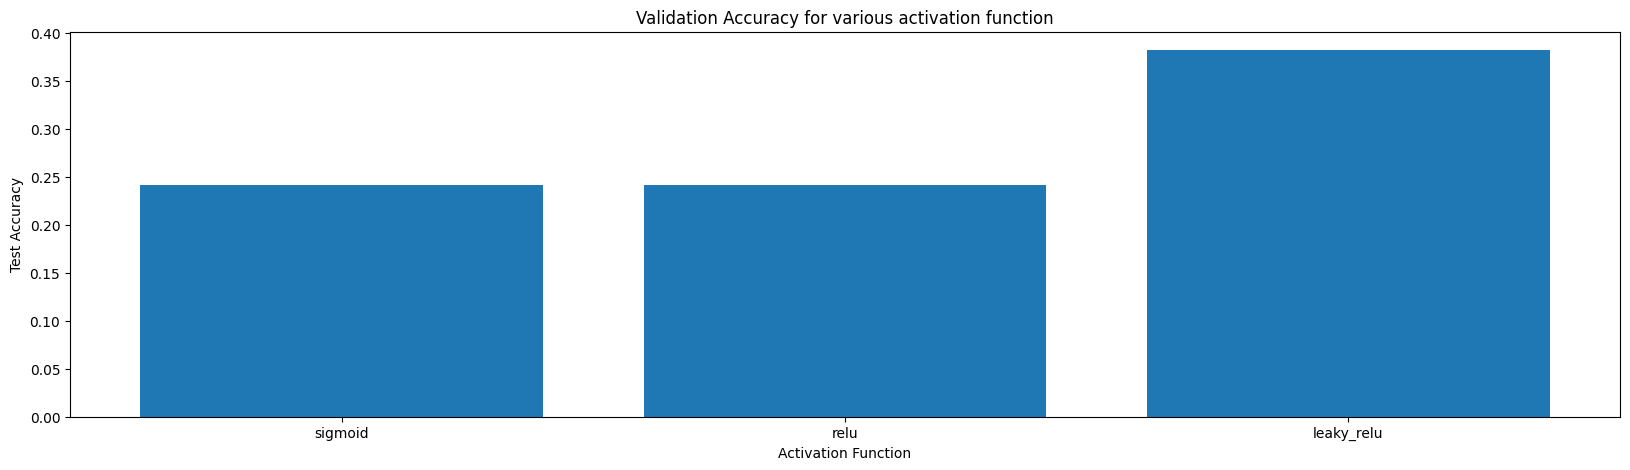

In [34]:
plt.figure(figsize=(20,5))
plt.bar(
    result_df_4['Activation Function'],
    result_df_4['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('Activation Function')
plt.title('Validation Accuracy for various activation function')
plt.show()

In [35]:
best_activation_function = result_df_4.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['Activation Function'].iloc[0]

best_activation_function

'leaky_relu'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2522 - f1_score: 0.2336 - loss: 138.3923 - val_accuracy: 0.3194 - val_f1_score: 0.2880 - val_loss: 1.5229
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3933 - f1_score: 0.3682 - loss: 1.4414 - val_accuracy: 0.3588 - val_f1_score: 0.3233 - val_loss: 1.4701
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4859 - f1_score: 0.4694 - loss: 1.3048 - val_accuracy: 0.3727 - val_f1_score: 0.3606 - val_loss: 1.4888
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5665 - f1_score: 0.5624 - loss: 1.1575 - val_accuracy: 0.3681 - val_f1_score: 0.3421 - val_loss: 1.4615
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6270 - f1_score: 0.6241 - loss: 1.0233 - val_accuracy: 0.3750 - val_f1_score: 0.3525 - val_loss: 1.5671
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7027 - f1_score: 0.7011 - loss: 0.8668 - val_accuracy: 0.3750 - val_f1_score: 0.3

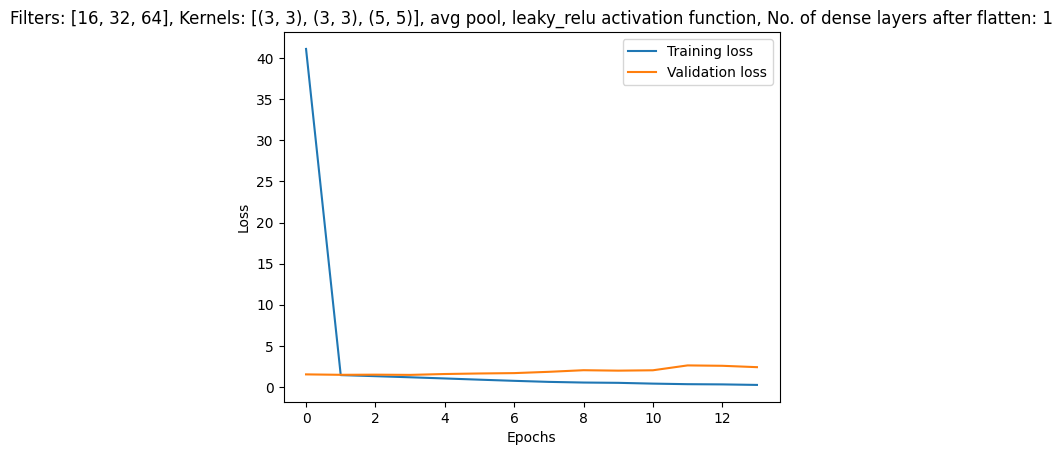

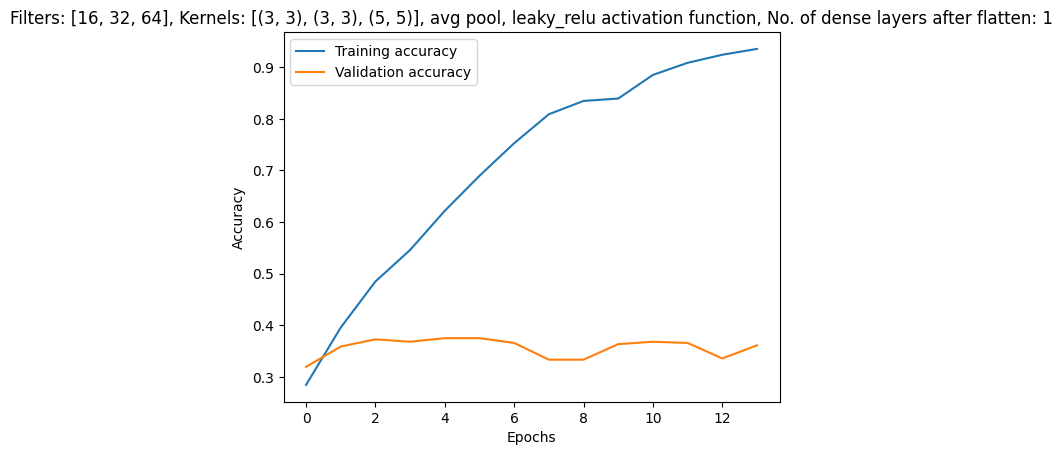

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


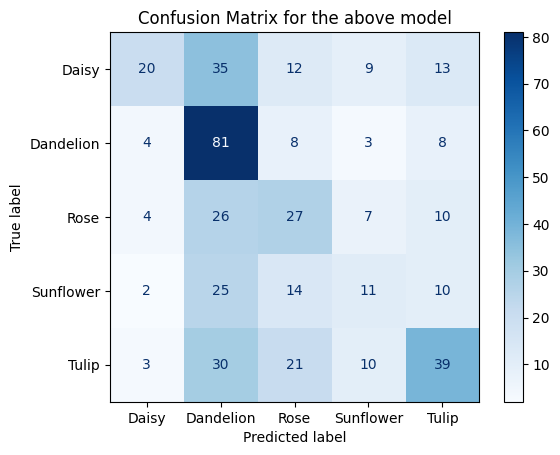

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2237 - f1_score: 0.2189 - loss: 427.3645 - val_accuracy: 0.3148 - val_f1_score: 0.3005 - val_loss: 1.6295
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3397 - f1_score: 0.3308 - loss: 1.6207 - val_accuracy: 0.3171 - val_f1_score: 0.2485 - val_loss: 1.6151
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3876 - f1_score: 0.3799 - loss: 1.4955 - val_accuracy: 0.2801 - val_f1_score: 0.2719 - val_loss: 1.5974
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4491 - f1_score: 0.4419 - loss: 1.3704 - val_accuracy: 0.2801 - val_f1_score: 0.1933 - val_loss: 1.9538
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4578 - f1_score: 0.4524 - loss: 1.3985 - val_accuracy: 0.3125 - val_f1_score: 0.2720 - val_loss: 1.6130
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5283 - f1_score: 0.5228 - loss: 1.2060 - val_accuracy: 0.3079 - val_f1_score: 0.2

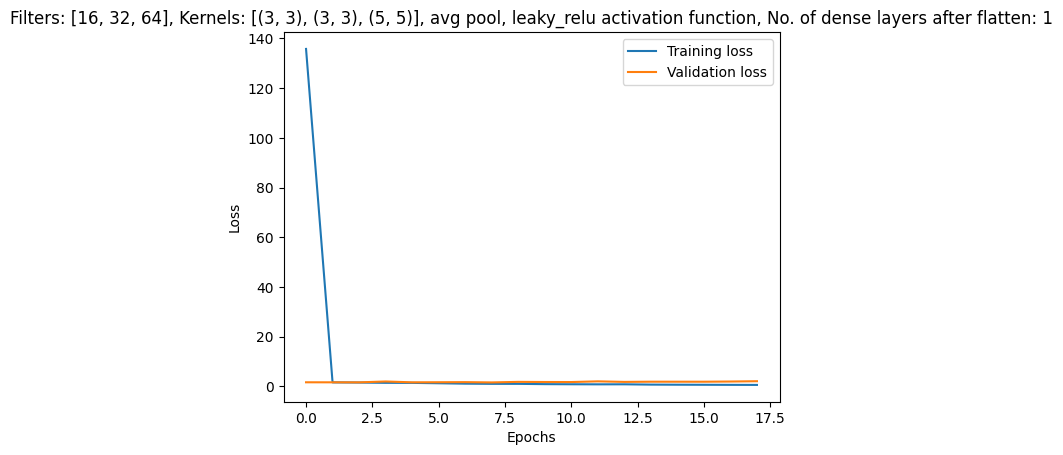

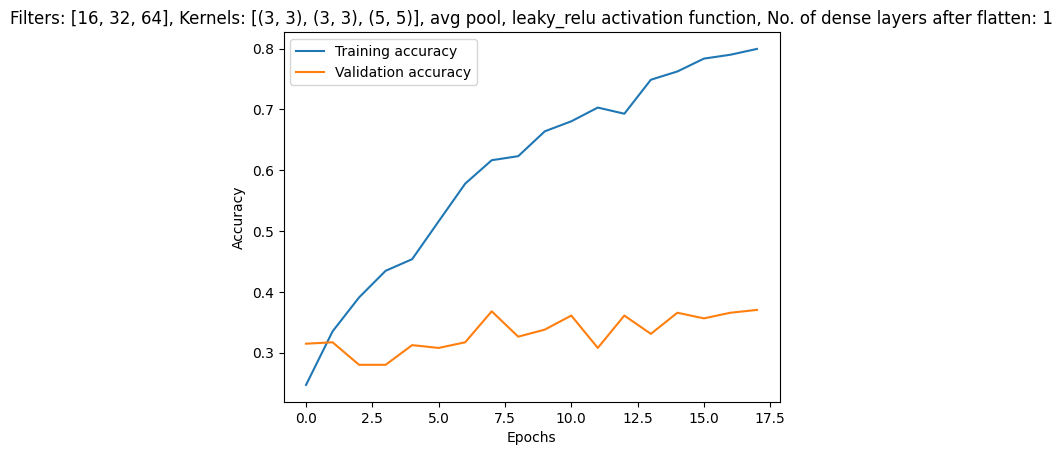

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


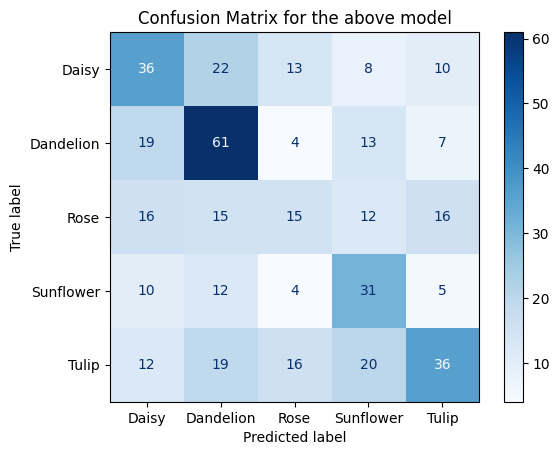

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ ?                           │     0 (unbuilt) │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2809 - f1_score: 0.2779 - loss: 6.3863 - val_accuracy: 0.2546 - val_f1_score: 0.2457 - val_loss: 1.9310
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5129 - f1_score: 0.4983 - loss: 1.2554 - val_accuracy: 0.3634 - val_f1_score: 0.3327 - val_loss: 2.3307
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6307 - f1_score: 0.6221 - loss: 0.9538 - val_accuracy: 0.3727 - val_f1_score: 0.3678 - val_loss: 2.7039
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - f1_score: 0.7527 - loss: 0.6373 - val_accuracy: 0.3472 - val_f1_score: 0.3152 - val_loss: 3.4834
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8450 - f1_score: 0.8446 - loss: 0.4310 - val_accuracy: 0.4005 - val_f1_score: 0.3834 - val_loss: 3.1063
Epoch 6/20
105/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9224 - f1_score: 0.9223 - loss: 0.2245

In [ ]:
# Subtask 5

result_df_5 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Batch Normalization Presence',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
dropout_rates = [0.1,0.25,0,0.1]
batch_norm=[False,False,True,True]
epochs = 20

for dropout_rate,add_batch in zip(dropout_rates,batch_norm):
  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=best_activation_function,
      pool=best_pool,
      dropout_rate=dropout_rate,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs,
      add_batch_normalization=add_batch
      )

  result_df_5.loc[len(result_df_5.index)]=[
      best_kernel,
      filters,
      best_pool,
      best_activation_function,
      best_num_dense,
      dropout_rate,
      test_loss,
      test_accuracy,
      test_f1,
      add_batch,
      train_time
  ]

In [ ]:
result_df_5

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(
    [f'Dropout rate: {drop} batch: {batch}' for drop,batch in zip(result_df_5['Dropout Rate'],result_df_5['Batch Normalization Presence'])],
    result_df_5['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('Regularization')
plt.title('Validation Accuracy for various regularization')
plt.show()

In [ ]:
best_dropout = result_df_5.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['Dropout Rate'].iloc[0]

best_dropout

In [ ]:
best_do_batch = result_df_5.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['Batch Normalization Presence'].iloc[0]

best_do_batch

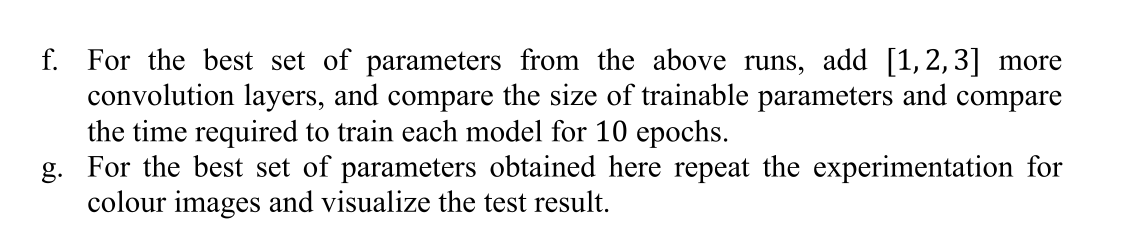

In [ ]:
# Subtask 6

result_df_6 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Batch Normalization Presence',
        'No. of Extra Conv Layers',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
epochs = 10
extra_conv_layers =  [0,1,2,3]


for c in extra_conv_layers:
  filter_copy=[]
  kernel_copy=[]

  for filt,ker in zip(filters,best_kernel):
    filter_copy.append(filt)
    kernel_copy.append(ker)

  test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=kernel_copy,
      filters=filter_copy,
      activation_func=best_activation_function,
      pool=best_pool,
      dropout_rate=best_dropout,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs,
      add_batch_normalization=best_do_batch,
      extra_conv_layers=c
      )

  result_df_6.loc[len(result_df_6.index)]=[
      kernel_copy,
      filter_copy,
      best_pool,
      best_activation_function,
      best_num_dense,
      best_dropout,
      test_loss,
      test_accuracy,
      test_f1,
      best_do_batch,
      c,
      train_time
  ]

In [ ]:
result_df_6

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(
    result_df_6['No. of Extra Conv Layers'],
    result_df_6['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('No. of Extra Conv Layers')
plt.title('Validation Accuracy for various extra conv layers')
plt.show()

In [ ]:
best_conv = result_df_6.sort_values(
    by=['Test Accuracy','Test F1 Score'],
    ascending=[False,False]
)['No. of Extra Conv Layers'].iloc[0]

best_conv

In [ ]:
# Subtask 7

# Prepare the RGB dataset

X_rgb = []  # Contains the images
Y_rgb = []  # Contains the labels

In [ ]:
def train_data_rgb(flower_type,path_dir):
  for img in tqdm(os.listdir(path_dir)):
        label=flower_type
        path = os.path.join(path_dir,img)
        img_array = Image.open(path)
        img_array = img_array.resize((IMG_SIZE,IMG_SIZE))
        img_array = np.array(img_array)
        X_rgb.append(np.array(img_array))
        Y_rgb.append(str(label))

In [ ]:
train_data_rgb('Daisy',FLOWER_DAISY_DIR)
train_data_rgb('Sunflower',FLOWER_SUNFLOWER_DIR)
train_data_rgb('Tulip',FLOWER_TULIP_DIR)
train_data_rgb('Dandelion',FLOWER_DANDI_DIR)
train_data_rgb('Rose',FLOWER_ROSE_DIR)

In [ ]:
import matplotlib.image as mpimg
plt.imshow(X_rgb[223])

print(Y_rgb[223])

In [ ]:
from sklearn.model_selection import train_test_split

X_train_rgb,X_rem_rgb,y_train_rgb,y_rem_rgb = train_test_split(X_rgb,Y_rgb,test_size=0.2,random_state=5)
X_test_rgb,X_val_rgb,y_test_rgb,y_val_rgb = train_test_split(X_rem_rgb,y_rem_rgb,test_size=0.5,random_state=5)

print(len(X_train_rgb))
print(len(y_train_rgb))
print(len(X_val_rgb))
print(len(y_val_rgb))
print(len(X_test_rgb))
print(len(y_test_rgb))

In [ ]:
# Convert to np array for tf processing
X_train_rgb=np.array(X_train_rgb)
X_val_rgb=np.array(X_val_rgb)
X_test_rgb=np.array(X_test_rgb)
y_train_rgb=np.array(y_train_rgb)
y_val_rgb=np.array(y_val_rgb)
y_test_rgb=np.array(y_test_rgb)

# Reshape
X_train_rgb = X_train_rgb.reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_val_rgb = X_val_rgb.reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_test_rgb = X_test_rgb.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
# One hot encode the labels
label_encoder = LabelEncoder()

label_encoder.fit(['Daisy','Sunflower','Tulip','Dandelion','Rose'])

y_train_rgb = label_encoder.transform(y_train_rgb)
y_val_rgb = label_encoder.transform(y_val_rgb)
y_test_rgb = label_encoder.transform(y_test_rgb)

y_train_rgb = pd.get_dummies(y_train_rgb,dtype='int').to_numpy()
y_val_rgb = pd.get_dummies(y_val_rgb,dtype='int').to_numpy()
y_test_rgb = pd.get_dummies(y_test_rgb,dtype='int').to_numpy()

In [ ]:
plt.imshow(X_train_rgb[24])
plt.show()

In [ ]:
y_train_rgb[24]

In [ ]:
result_df_7 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Batch Normalization Presence',
        'No. of Extra Conv Layers',
        'Color Mode',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
epochs = 20

test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=best_activation_function,
      pool=best_pool,
      dropout_rate=best_dropout,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs,
      add_batch_normalization=best_do_batch,
      extra_conv_layers=best_conv
      )

result_df_7.loc[len(result_df_7.index)]=[
      best_kernel,
      filters,
      best_pool,
      best_activation_function,
      best_num_dense,
      best_dropout,
      test_loss,
      test_accuracy,
      test_f1,
      best_do_batch,
      best_conv,
      'grayscale',
      train_time
  ]

test_loss,test_accuracy,test_f1,train_time,_ = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=best_activation_function,
      pool=best_pool,
      dropout_rate=best_dropout,
      num_dense_layers=best_num_dense,
      X_train=X_train_rgb,
      y_train=y_train_rgb,
      X_test=X_test_rgb,
      y_test=y_test_rgb,
      num_epochs=epochs,
      add_batch_normalization=best_do_batch,
      extra_conv_layers=best_conv,
      is_rgb=True
      )

result_df_7.loc[len(result_df_7.index)]=[
      best_kernel,
      filters,
      best_pool,
      best_activation_function,
      best_num_dense,
      best_dropout,
      test_loss,
      test_accuracy,
      test_f1,
      best_do_batch,
      best_conv,
      'rgb',
      train_time
  ]



In [ ]:
result_df_7

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(
    result_df_7['Color Mode'],
    result_df_7['Test Accuracy']
)

plt.ylabel('Test Accuracy')
plt.xlabel('Color Mode')
plt.title('Validation Accuracy for various color modes')
plt.show()

##### Clearly the model performs better with rgb channel images

## **Question 05**

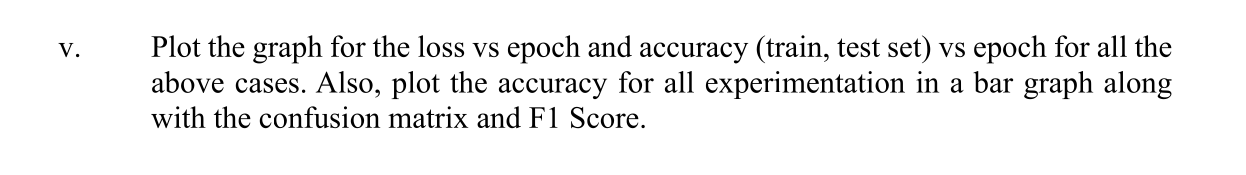

Already done in continuation of question 4

## **Question 06**
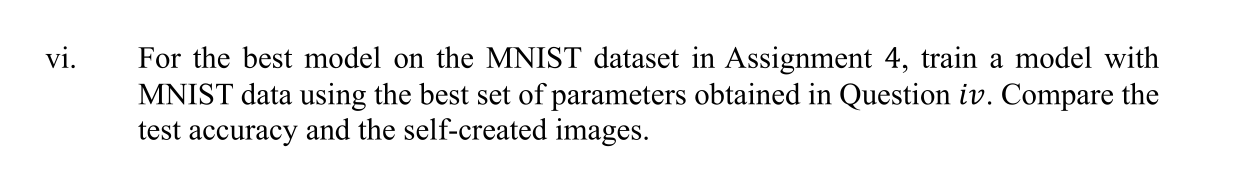

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
X_train = np.concatenate((X_train, X_test),axis=0)
y_train = np.concatenate((y_train, y_test),axis=0)
X_train.shape

In [ ]:
# Training Data -> 80% , Validation Data -> 10% , Testing Data -> 10%

from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X_train, y_train, test_size=0.2, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=4)

In [ ]:
# Resizing to 80x80
from tensorflow.image import resize

X_train = np.reshape(X_train,(-1,28,28,1))
X_train=X_train/255
X_train = resize(X_train,(80,80))

X_val = np.reshape(X_val,(-1,28,28,1))
X_val=X_val/255
X_val = resize(X_val,(80,80))

X_test = np.reshape(X_test,(-1,28,28,1))
X_test=X_test/255
X_test = resize(X_test,(80,80))

In [ ]:
plt.imshow(X_train[23],cmap='Greys')

In [ ]:
y_train[23]

In [ ]:
# Categorical encoding of y
y_train = pd.get_dummies(y_train,dtype='int').to_numpy()
y_val = pd.get_dummies(y_val,dtype='int').to_numpy()
y_test = pd.get_dummies(y_test,dtype='int').to_numpy()

y_train[23]

In [ ]:
result_df_8 = pd.DataFrame(
    columns=[
        'Conv Kernel Size',
        'Conv Filter Size',
        'Pooling Layers',
        'Activation Function',
        'No. of Dense Layers after Flatten',
        'Dropout Rate',
        'Test Loss',
        'Test Accuracy',
        'Test F1 Score',
        'Batch Normalization Presence',
        'No. of Extra Conv Layers',
        'Color Mode',
        'Training Time(in seconds)'
    ]
)

filters = [16,32,64]
epochs = 20

test_loss,test_accuracy,test_f1,train_time,model = train_model(
      kernels=best_kernel,
      filters=filters,
      activation_func=best_activation_function,
      pool=best_pool,
      dropout_rate=best_dropout,
      num_dense_layers=best_num_dense,
      X_train=X_train,
      y_train=y_train,
      X_test=X_test,
      y_test=y_test,
      num_epochs=epochs,
      add_batch_normalization=best_do_batch,
      extra_conv_layers=best_conv,
      is_mnist=True
      )

result_df_8.loc[len(result_df_8.index)]=[
      best_kernel,
      filters,
      best_pool,
      best_activation_function,
      best_num_dense,
      best_dropout,
      test_loss,
      test_accuracy,
      test_f1,
      best_do_batch,
      best_conv,
      'grayscale',
      train_time
  ]

In [ ]:
import random

random_indices = random.sample(range(0,len(X_test)),10)

img_predict = np.array([X_test[ind] for ind in random_indices])
true_label = np.array([y_test[ind] for ind in random_indices])

cat_pred = model.predict(img_predict)

for img,cat_pred,true_val in zip(img_predict,cat_pred,true_label):
  plt.imshow(img,cmap="Greys")
  plt.show()
  prediction=np.argmax(cat_pred)
  print(f"Predicted value:- {prediction}")
  print(f"True value:- {np.argmax(true_val)}")

As we can see there is 100% accuracy achieved here, which was not the case for the earlier assignment's ANN model